# Signal super resolution

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
in_colab = False
try:
    import google.colab
    in_colab = True
except:
    in_colab = False
in_colab

True

In [3]:
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
font = {'family' : '',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [4]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [5]:
import pandas as pd
columns = ["Method", "MSE", "SSIM", "PSNR", "Time (s)"]
df = pd.DataFrame(columns = columns)
df.head()

,Method,MSE,SSIM,PSNR,Time (s)


In [6]:
import os
import torch
import numpy as np

In [7]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [8]:
labels = ["MI", "STTC", "CD", "HYP", "NORM"]

In [9]:
if in_colab:
  from google.colab import drive
  drive.mount("/content/drive/", force_remount = True)
  %cd "drive/MyDrive/Colab Notebooks/ECG_SuperResolution"
  !ls

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/ECG_SuperResolution
 activationmap_superresolution_labelCD_ch0-1_noised.png
 activationmap_superresolution_labelCD_nonoise.png
 activationmap_superresolution_labelCD.png
 activationmap_superresolution_labelHYP_ch0-1_noised.png
 activationmap_superresolution_labelHYP_nonoise.png
 activationmap_superresolution_labelHYP.png
 activationmap_superresolution_labelMI_ch0-1_noised.png
 activationmap_superresolution_labelMI_nonoise.png
 activationmap_superresolution_labelMI.png
 activationmap_superresolution_labelNORM_ch0-1_noised.png
 activationmap_superresolution_labelNORM_nonoise.png
 activationmap_superresolution_labelNORM.png
 activationmap_superresolution_labelSTTC_ch0-1_noised.png
 activationmap_superresolution_labelSTTC_nonoise.png
 activationmap_superresolution_labelSTTC.png
 classifier_hr.pt
 classifier_lr.pt
 CNNclassifier.ipynb
 convert_models.ipynb
 data
 ECG-AESR_explainability.ipynb
 ECG-AESR_MultiMode_Wavelets+ECG.

In [10]:
dict_windows_test_hr = {}
dict_windows_test_lr = {}
dict_windows_train_lr = {}
dict_windows_test_lr_n = {}
dict_windows_train_lr_n = {}
dict_windows_train_hr = {}
path = os.getcwd()+os.sep+"pt_data"+os.sep

for label in labels:

    print(label)
    filename = path + "test_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_test_hr[label] = hr_data

    filename = path + "test_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr[label] = lr_data


    filename = path + "test_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr_n[label] = lr_data

    """
    filename = path + "train_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_train_hr[label] = hr_data

    filename = path + "train_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr[label] = lr_data

    filename = path + "train_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr_n[label] = lr_data
    """

#dict_windows_train = dict_windows_train_lr
dict_windows_test = dict_windows_test_lr

MI
STTC
CD
HYP
NORM


In [11]:
fs_lr = 50
fs_hr = 500

In [12]:
from scipy import interpolate
import pywt

In [13]:
def wav_sr(signal, nchs=12):
    coeffs = pywt.wavedec(signal, 'db1', level=3)
    coeffs[1:] = [c * 2 for c in coeffs[1:]]  # Amplify high-frequency components
    sr = pywt.waverec(coeffs, 'db1')
    return sr

In [14]:
def compute_sr(signals, method, signals_hr = None, nchs = 12):
    signals_sr = []
    n = len(signals)
    for i, signal in enumerate(signals):
        print("\r", i+1, "/", n, end = "")
        signal = signal.cpu().detach().numpy()
        if signals_hr is None:
            signal_sr = method(signal, nchs=nchs)
        else:
            signal_hr = signals_hr[i]
            signals_hr = method(signal, signal_hr, nchs=nchs)
        if isinstance(signal_sr, (np.ndarray, np.generic) ):
            signal_sr = torch.from_numpy(signal_sr)
        signals_sr.append(signal_sr)
    signals_sr = torch.stack(signals_sr)
    width_sr = signals_sr.shape[-1]
    width_lr = signal.shape[-1]
    if method != "our proposed (S)":
        if width_lr == width_sr:
            signals_sr = interpolate_sr(signals_sr)
    return signals_sr

In [15]:
from torch.functional import F
def compute_mse(signals_sr, signals_hr):
    losses = []
    for i, signal_sr in enumerate(signals_sr):
        signal_sr = signal_sr.cpu()
        signal_hr = signals_hr[i].cpu()
        mse_loss = F.mse_loss(signal_sr, signal_hr)
        losses.append(mse_loss.item())
    return losses, np.mean(losses)

In [16]:
def interpolate_sr(signals, fs_lr=50, fs_hr = 500, nchs=12, mode = 'cubic'):
    # Interpolation to 500 Hz
    t_low_res = np.arange(0, 5, 1/fs_lr)
    t_high_res = np.arange(0, 5, 1/fs_hr)  # 500 Hz sampling rate
    signals_sr = []
    for signal in signals:
        f_interp = interpolate.interp1d(t_low_res, signal, kind=mode, fill_value="extrapolate")
        signal_sr = f_interp(t_high_res)
        if isinstance(signal_sr, (np.ndarray, np.generic) ):
            signal_sr = torch.from_numpy(signal_sr)
        signals_sr.append(signal_sr)
    signals_sr = torch.stack(signals_sr)
    return signals_sr

In [17]:
if in_colab:
  !pip install torchinfo
  !pip install neurokit2
  !pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.2/689.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 10.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-man

In [18]:
if in_colab:
  #!pip install ssqueezepy
  !pip install wfdb
  !pip install pycwt
  #!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118
  #!pip install matplotlib==3.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.5/753.5 kB 5.9 MB/s eta 0:00:00


In [19]:
def ssim_2d(signal1, signal2):
    """
    Compute the Structural Similarity Index (SSIM) for two-dimensional signals.

    Parameters:
    - signal1, signal2: Input signals.

    Returns:
    - ssim_index: Structural Similarity Index between the two signals.
    """

    # Ensure the signals have the same shape
    if signal1.shape != signal2.shape:
        raise ValueError("Input signals must have the same shape")

    # Constants for SSIM calculation
    C1 = (0.01 * np.amax(signal1) - np.amin(signal1))**2
    C2 = (0.01 * np.amax(signal2) - np.amin(signal2))**2

    # Mean and variance
    mu1 = np.mean(signal1)
    mu2 = np.mean(signal2)

    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = np.var(signal1)
    sigma2_sq = np.var(signal2)
    sigma12 = np.cov(signal1.flatten(), signal2.flatten())[0, 1]

    # SSIM calculation
    num = (2 * mu1_mu2 + C1) * (2 * sigma12 + C2)
    den = (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)

    #print(num, den)
    ssim_index = num / den

    return ssim_index

In [21]:
from scipy.fftpack import fft, ifft

# Frequency Domain Super-Resolution
def fft_sr(signal, nchs=12):
    signal = signal[0]
    N = signal.shape[-1]
    signal_sr = ifft(fft(signal, N * 10)[:N])
    signal_sr = torch.from_numpy(signal_sr).float()
    #print(signal_sr.shape)
    return signal_sr

In [20]:
def compute_ssim(signals_sr, signals_hr):

    ssims = []
    for i, signal_sr in enumerate(signals_sr):
        signal_sr = signal_sr.cpu()
        signal_hr = signals_hr[i].cpu()
        signal_sr = torch.squeeze(signal_sr, dim =0).cpu().detach().numpy()
        signal_hr = torch.squeeze(signal_hr, dim =0).cpu().detach().numpy()
        ssim = ssim_2d(signal_hr, signal_sr)
        ssims.append(ssim)
    return ssims, np.mean(ssims)

In [22]:
def psnr_2d(original, reconstructed):
    """
    Compute Peak Signal-to-Noise Ratio (PSNR) for two-dimensional signals.

    Parameters:
    - original: Original signal.
    - reconstructed: Reconstructed signal.

    Returns:
    - psnr_value: PSNR value between the original and reconstructed signals.
    """

    # Ensure the signals have the same shape
    if original.shape != reconstructed.shape:
        raise ValueError("Input signals must have the same shape")

    # Calculate the mean squared error
    mse = np.mean((original - reconstructed)**2)

    # The maximum possible pixel value (assuming the signal is in the range [0, 1])
    max_pixel_value = 1.0

    # Calculate PSNR
    psnr_value = 10 * np.log10((max_pixel_value**2) / mse)

    return psnr_value

In [23]:
def compute_psnr(signals_hr, signals_sr):

    psnrs = []
    for i, signal_sr in enumerate(signals_sr):
        signal_sr = signal_sr.cpu()
        signal_hr = signals_hr[i].cpu()
        signal_sr = torch.squeeze(signal_sr, dim =0).cpu().detach().numpy()
        signal_hr = torch.squeeze(signal_hr, dim =0).cpu().detach().numpy()
        psnr = psnr_2d(signal_hr, signal_sr)
        psnrs.append(psnr)
    return psnrs, np.mean(psnrs)

In [24]:
def sr_our_proposed_onlysignals(signal, nchs=12):

    global model
    global device

    signal = torch.from_numpy(signal).to(device)
    if signal.ndim == 2:
        signal = signal.unsqueeze(dim = 0)
    if signal.ndim == 3:
        signal = signal.unsqueeze(dim = 0)
    pred = model([signal, None, None, None])
    signal_sr = pred[1]
    if signal_sr.ndim == 2:
        signal_sr = signal_sr.unsqueeze(dim = 0)
    signal_sr = signal_sr.cpu().detach().numpy()

    #print(signal_sr.shape)
    del pred
    del signal
    return signal_sr

In [25]:
from scipy.signal import resample as sc_resample
import gc

def scipy_resample(signal, nchs = 12, size = 2500):

    gc.collect()
    signal_sr = np.zeros((nchs, size))
    for ch in range(nchs):
        signal_ch = signal[0, ch]
        signal_sr[ch, :]= sc_resample(signal_ch, size)
    #print(signal_sr.shape)
    return signal_sr

In [26]:
from functions import *

In [27]:
def filter_interp(signals, nchs = 12):

    signals = torch.from_numpy(signals)
    interp_datas = []
    for signal in signals:
        filtered_data = myfilter(0.05, signal, powerline = None)
        interp_data = interpolate_sr(filtered_data, fs_lr=50, fs_hr = 500, nchs=nchs, mode = 'cubic')
        interp_datas.append(interp_data)

    interp_datas = torch.stack(interp_datas)
    return interp_datas

In [28]:
methods = ["Filter + Interpolation", "Interpolation", "DCAE-SR"]
functions = [filter_interp, interpolate_sr, sr_our_proposed_onlysignals]
methods = {method:functions[i] for i, method in enumerate(methods)}

In [29]:
device = "cuda:0"
model_path = os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_lrhr_v2.pt"
model = torch.load(model_path)
model = model.to(device)
model.eval()

VAE1d_SR_multimodal(
  (encoder): Encoder1d(
    (encoder): Sequential(
      (0): EncoderBlock1d(
        (conv1d_in): Conv1d(12, 12, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=False)
        (conv1d_out): Conv1d(12, 192, kernel_size=(3,), stride=(1,))
        (activation_out): Tanh()
        (dropout_out): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderBlock1d(
        (conv1d_in): Conv1d(192, 384, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=False)
        (conv1d_out): Conv1d(384, 768, kernel_size=(3,), stride=(1,))
        (activation_out): Tanh()
        (dropout_out): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Decoder1d(
    (decoder): Sequential(
      (0): DecoderBlock1d(
        (conv1d_in): ConvTranspose1d(768, 768, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=

In [ ]:
import time
import plotly
from plotly import graph_objects as go

df = pd.DataFrame(columns = columns)
model = model.eval()
model = model.to(device)

decoder = model.decoder.decoder
decoder_sr = model.upsample.decoder
for j, block in enumerate(decoder):
  if j+1 == 2:
    block.last_tanh = False
  else:
    block.last_tanh = True

for j, block in enumerate(decoder_sr):
  if j+1 == 2:
    block.last_tanh = False
  else:
    block.last_tanh = True

colors = ["red", "orange", "yellow", "green", "cyan", "blue"]
fig = go.Figure()
fig1 = go.Figure()
fig2 = go.Figure()

label = "MI"
signals_test = dict_windows_test_lr_n[label]
signals_test_hr = dict_windows_test_hr[label]

for i, (method, function) in enumerate(methods.items()):

    print(method)

    color = colors[i]

    t0 = time.time()
    #compute method sr from low res
    if method == "sparse_representation_sr":
        signals_test_sr = compute_sr(signals_test, function, signals_hr = signals_test_hr)
    else:
        signals_test_sr = compute_sr(signals_test, function)

    if signals_test_sr.ndim == 3:
        signals_test_sr = torch.unsqueeze(signals_test_sr, dim = 1)

    #print(signals_test_sr.shape, signals_test_hr.shape)
    #compute mse
    mses, mse = compute_mse(signals_test_sr, signals_test_hr)
    #compute ssmi
    ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
    #compute psnr
    psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)
    tend = time.time()
    ex_time = round(tend-t0, 3)
    values = [method, mse, ssim, psnr, ex_time]
    df.loc[i] = values

    fig.add_trace(go.Box(
            y=mses,
            name="<b>"+method+"</b>",
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=color,
            marker_size=2,
            line_width=1)
    )

    fig1.add_trace(go.Box(
            y=ssims,
            name="<b>"+method+"</b>",
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=color,
            marker_size=2,
            line_width=1)
    )

    fig2.add_trace(go.Box(
            y=psnrs,
            name="<b>"+method+"</b>",
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=color,
            marker_size=2,
            line_width=1)
    )

    del signals_test_sr
    print("\n")

fig.update_layout(autosize = False, width = 800, height = 800, template = "simple_white", legend = dict(font = dict(size = 18)), font=dict(size=14), yaxis = dict(tickfont = dict(size=16)))
fig.show()
fig1.update_layout(autosize = False, width = 800, height = 800, template = "simple_white",  legend = dict(font = dict(size = 18)), font=dict(size=14), yaxis = dict(tickfont = dict(size=16)))
fig1.show()
fig2.update_layout(autosize = False, width = 800, height = 800, template = "simple_white",  legend = dict(font = dict(size = 18)), font=dict(size=14), yaxis = dict(tickfont = dict(size=16)))
fig2.show()

Filter + Interpolation
 1088 / 1088

Interpolation
 1088 / 1088

DCAE-SR
 1088 / 1088



In [ ]:
gc.collect()

326

In [ ]:
df.set_index("Method", inplace = True)

In [ ]:
df

,MSE,SSIM,PSNR,Time (s)
Method,,,,
Filter + Interpolation,0.097055,0.969988,15.587837,13.239
Interpolation,0.185235,0.967726,14.789180,3.112
DCAE-SR,0.003992,0.997919,25.701348,14.956


In [30]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = "24"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = "24"

In [31]:
font = {'family' : '',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [32]:
model.eval()

decoder = model.decoder.decoder
decoder_sr = model.upsample.decoder
for j, block in enumerate(decoder):
  if j+1 == 2:
    block.last_tanh = False
  else:
    block.last_tanh = True

for j, block in enumerate(decoder_sr):
  if j+1 == 2:
    block.last_tanh = False
  else:
    block.last_tanh = True

Filter + Interpolation
torch.Size([1, 1, 12, 250]) torch.Size([1, 1, 12, 2500])
 1 / 1Interpolation
torch.Size([1, 1, 12, 250]) torch.Size([1, 1, 12, 2500])
 1 / 1DCAE-SR
torch.Size([1, 1, 12, 250]) torch.Size([1, 1, 12, 2500])
 1 / 1

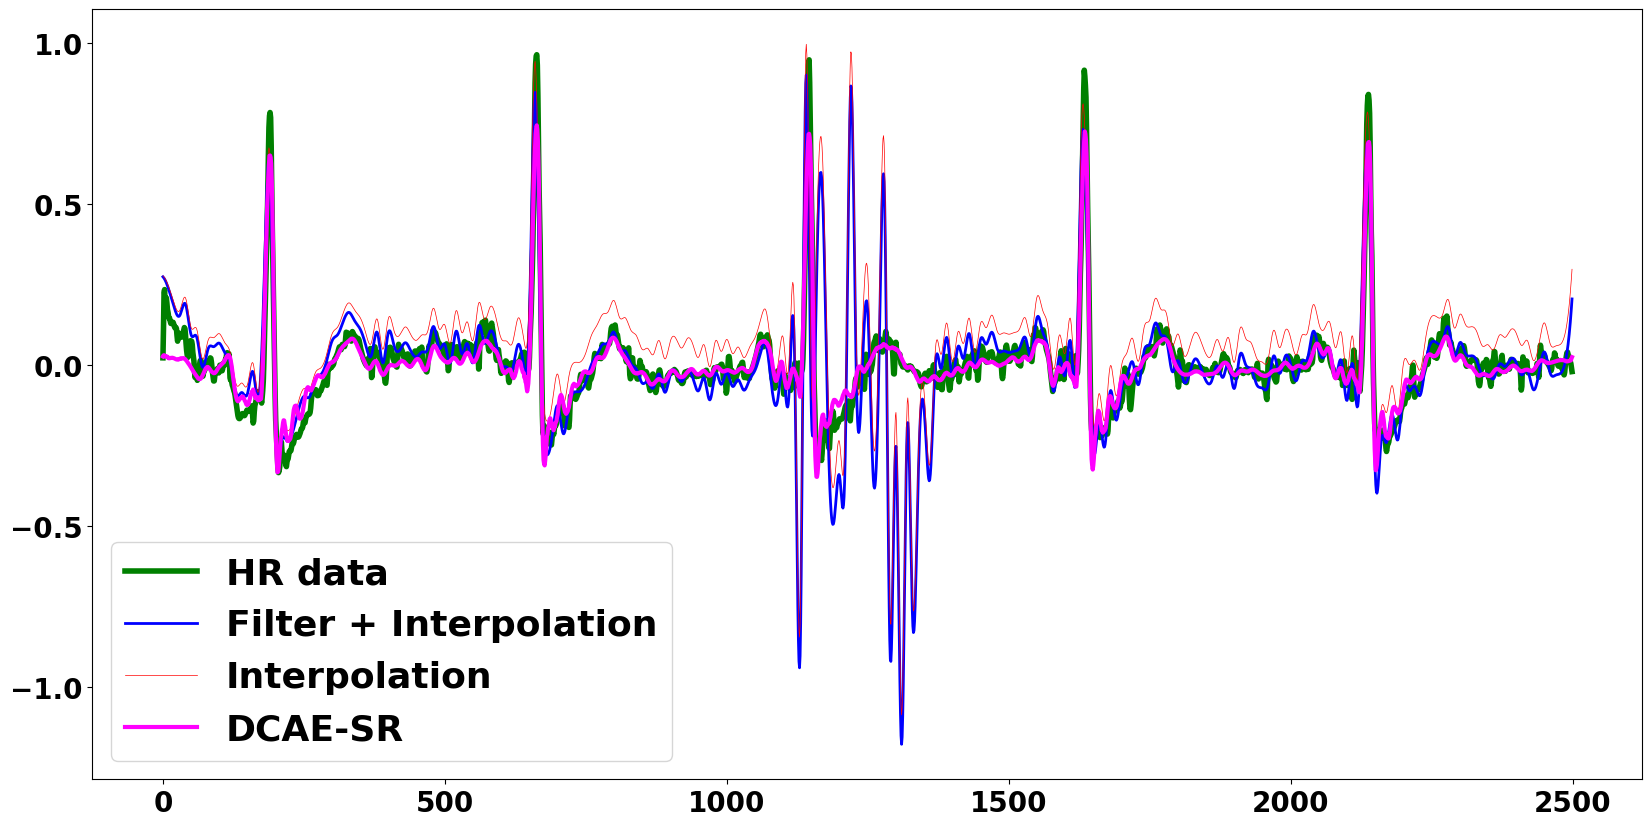

In [ ]:
idx = 520
nchs = 12
ch = 0
label = "MI"
lr_data = dict_windows_test_lr_n[label][idx][ch].cpu()#dict_windows_test_lr_n[label][idx][ch].cpu()
hr_data = dict_windows_test_hr[label][idx][ch].cpu()
fig = plt.figure(figsize = (20, 10))
colors = ["green", "blue", "red", "magenta"]

while True:
    if lr_data.ndim == 4:
        break
    else:
        lr_data = torch.unsqueeze(lr_data, dim = 0)

while True:
    if hr_data.ndim == 4:
        break
    else:
        hr_data = torch.unsqueeze(hr_data, dim = 0)

i = 0
plt.plot(hr_data[0, 0, ch, :], color = colors[0], label = "HR data", linewidth = 4)
i+=1

for (method, function) in methods.items():

    print(method)
    print(lr_data.shape, hr_data.shape)
    #compute method sr from low res
    if method == "sparse_representation_sr":
      sr_data = compute_sr(lr_data, function, signals_hr = hr_data)
    else:
      sr_data = compute_sr(lr_data, function)

    if sr_data.ndim == 3:
      sr_data = torch.unsqueeze(sr_data, dim = 1)

    color = colors[i]
    if method == "DCAE-SR":
      linewidth = 3
    elif method == "Filter + Interpolation":
      linewidth = 2
    else:
      linewidth = 0.5
    plt.plot(sr_data[0, 0, ch, :], color = color, label = method, linewidth = linewidth)
    i+=1
plt.legend(fontsize="26")

In [ ]:
fig.savefig("sr_EMGnoise_comparison.png", dpi=300)

In [ ]:
channels = ["I", "II", "III", "aVL", "aVR", "aVF", "V1", "V2", "V3", "V4", "V5", "V6" ]
channels_map = {idx: channel for idx, channel in enumerate(channels)}

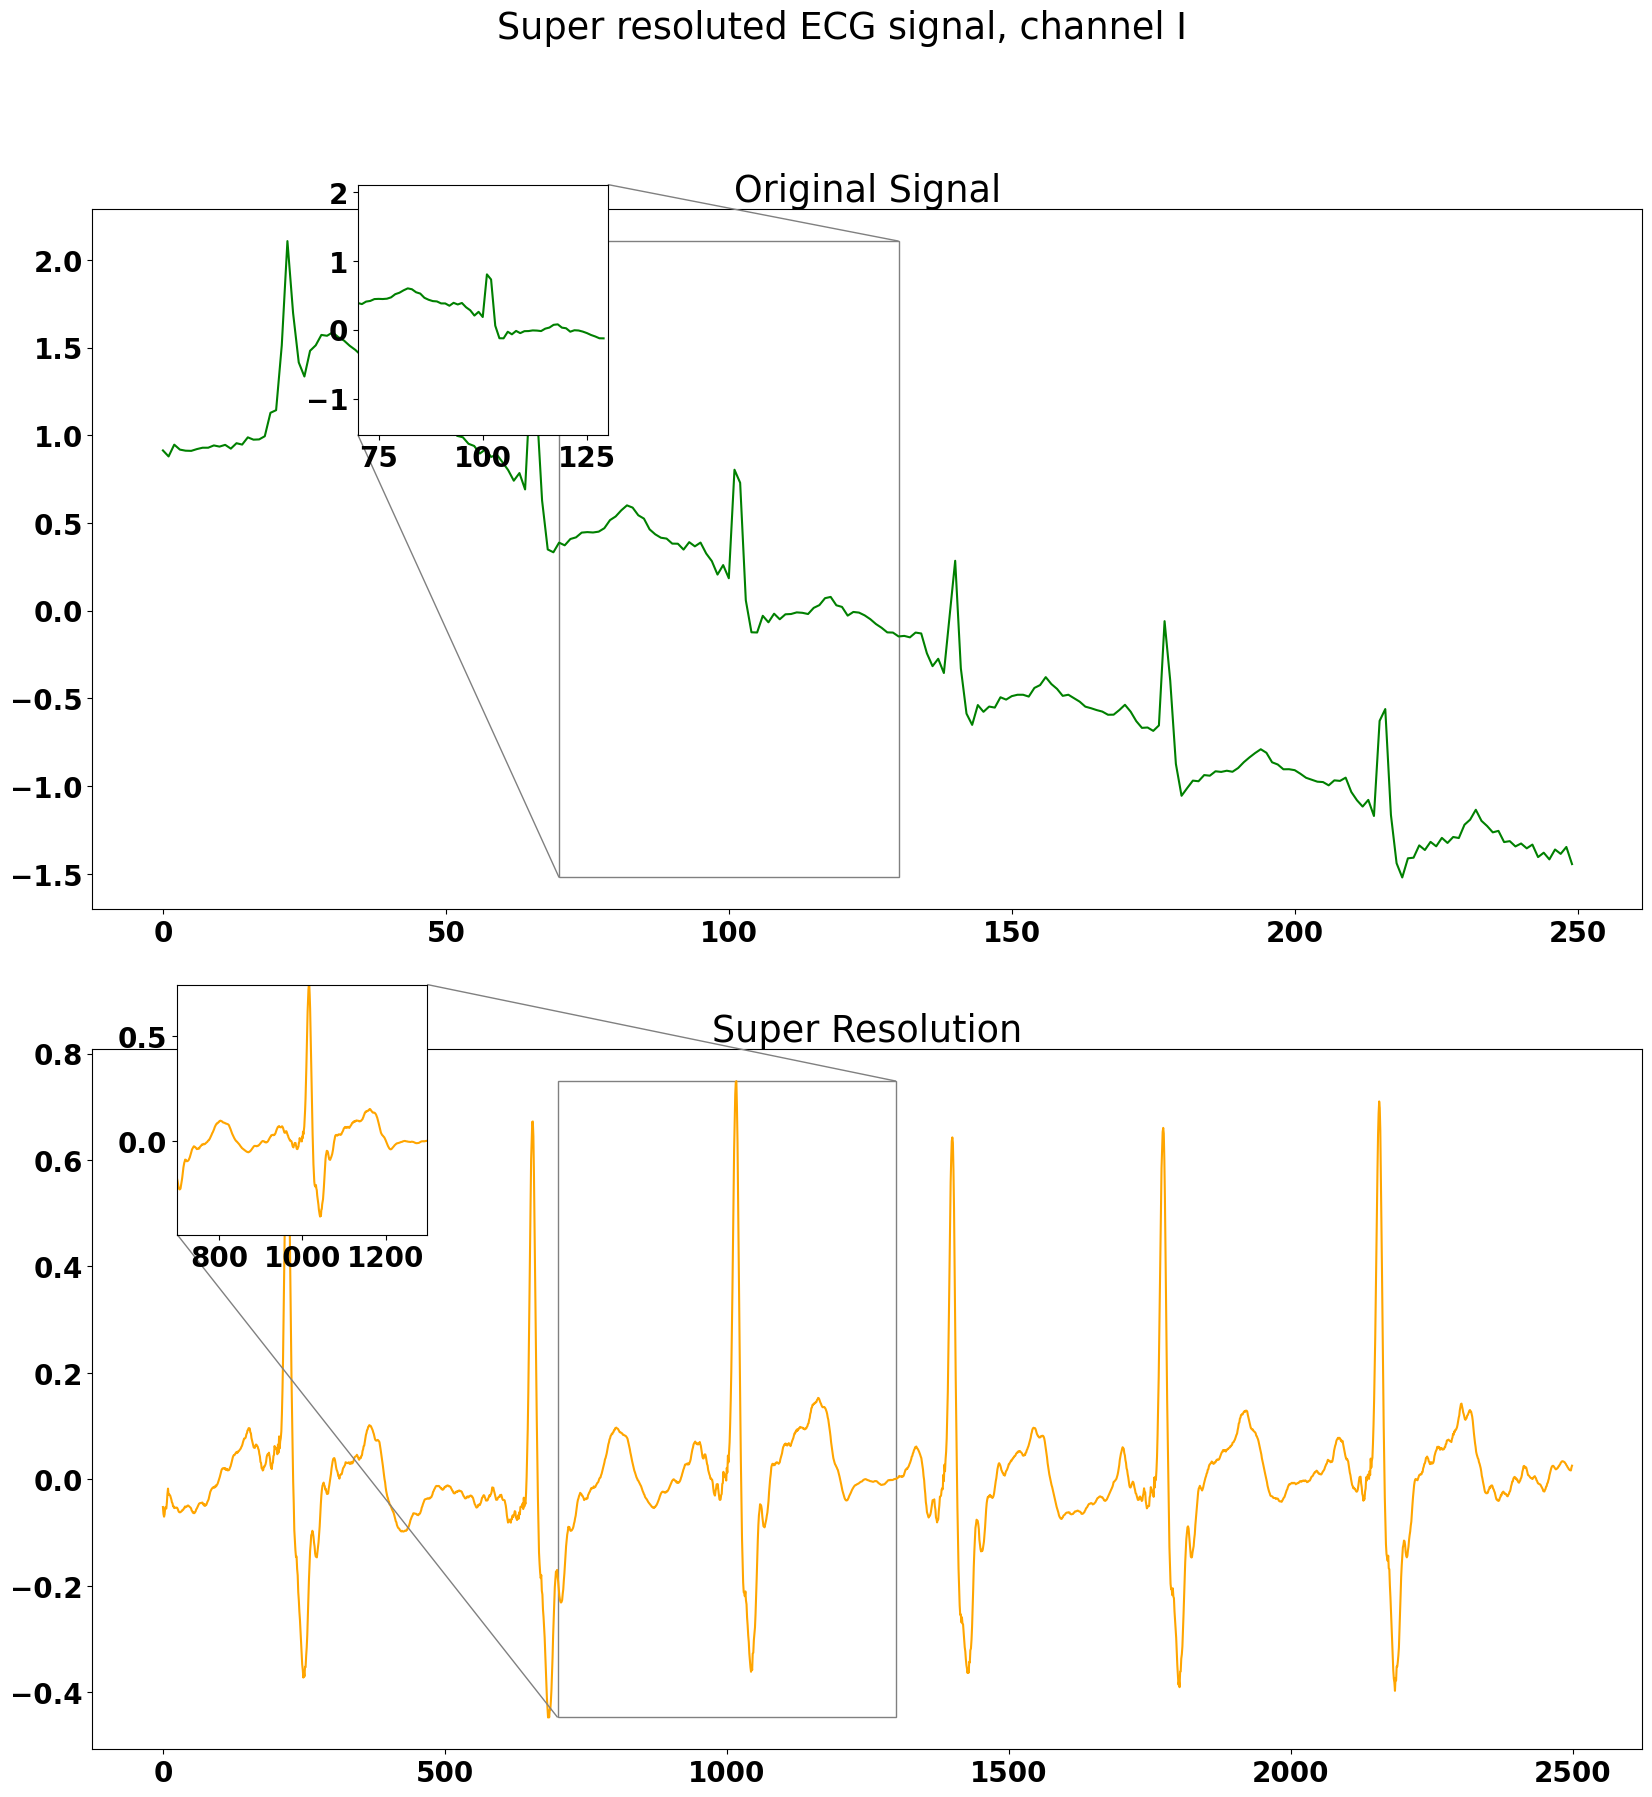

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes

idx = 150
label = "MI"

to_predict_lr = dict_windows_test_lr_n[label][idx][0, :, :]
to_predict_hr = dict_windows_test_hr[label][idx][0, :, :]

channel = "All Channels"
fig, axs = plt.subplots(2, figsize=(20, 20))
if channel == "All Channels":
  channel_m = channels_map[0]
else:
  channel_m = channels_map[channel]
fig.suptitle("Super resoluted ECG signal, channel {}".format(channel_m))


model = model.to(device)
model.eval()
pred = model([to_predict_lr.to(device), None, None, None])
n1 = to_predict_lr.shape[-1]
t1 = np.arange(0, n1, 1)
sig_or = torch.squeeze(to_predict_lr).cpu().detach().numpy()
sig_sr = torch.squeeze(pred[1]).cpu().detach().numpy()
n2 = sig_sr.shape[-1]
t2 = np.arange(0, n2, 1)

for i in range(2):

    ax = axs[i]

    if i == 1:
        t = t2
        title = "Super Resolution"
        if channel != "All Channels":
            y = sig_sr[:]
        else:
            y = sig_sr[0, :]
            channel_m = channels_map[0]
        axins = inset_axes(ax, 2.5, 2.5, loc=1, bbox_to_anchor=(.3, 0.5),bbox_transform=fig.transFigure)
        color = "orange"
    else:
        t = t1
        title = "Original Signal"
        if channel != "All Channels":
            y = sig_or[:]
        else:
            y = sig_or[0, :]
            channel_m = channels_map[0]
        axins = inset_axes(ax, 2.5, 2.5, loc=2, bbox_to_anchor=(.25, 0.9),bbox_transform=fig.transFigure)
        color = "g"

    ax.plot(t, y, color)
    ax.title.set_text(title)

    if i == 0:
        i1, i2 = 70, 130# specify the limits
    else:
        i1, i2 = 70*10, 130*10

    axins.plot(t[i1:i2], y[i1:i2], color)

    axins.set_xlim(t[i1], t[i2]) # apply the x-limits
    axins.set_ylim(min(y), max(y)) # apply the y-limits

    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")

plt.show()

In [ ]:
fig.savefig("super_resolution_zoom.jpg", dpi=600)

In [43]:
idx = 100#50
signal = dict_windows_test_lr[label][idx, 0]
signal_hr = dict_windows_test_hr[label][idx, 0]
signal.shape, signal_hr.shape

(torch.Size([12, 250]), torch.Size([12, 2500]))

In [34]:
import scipy
def resample_single(to_resample, nchs = 12, size = 5*50):

    resampled_data = np.zeros((nchs, size))
    for ch in range(nchs):
        resampled_data[ch, :] = scipy.signal.resample(x=to_resample[ch, :], num=size)

    return resampled_data

In [35]:
import random
import neurokit2 as nk
def add_rsp(signal):

    nchs = 12
    duration = 5
    fs = 50

    while True:
        rr_all = np.arange(10, 20, 2)
        rr = random.choice(rr_all)
        #print(rr)
        resp = nk.rsp_simulate(length=fs*duration, sampling_rate = fs, respiratory_rate=rr, method="breathmetrics")

        temp = [torch.from_numpy(resp) for i in range(nchs)]
        resp = torch.from_numpy(np.array(temp))

        if signal.shape == resp.shape:
            break
    noisy_signal = signal.cpu() + resp

    return noisy_signal

In [36]:
def add_emg(signal):

    nchs = 12
    duration = 5
    fs = 50

    bn = random.choice(np.arange(1, 2))
    emg = nk.emg_simulate(length=fs*duration, sampling_rate = fs, burst_number=bn, burst_duration=1)

    temp = [torch.from_numpy(emg) for i in range(nchs)]
    emg = torch.from_numpy(np.array(temp))
    noisy_signal = signal.cpu() + emg
    return noisy_signal

In [37]:
def add_eda(signal):

    nchs = 12
    duration = 5
    fs = 50

    edan = random.choice(np.arange(1, 2))
    eda = nk.eda_simulate(duration = 5, length=fs*duration, sampling_rate = fs, scr_number=edan, drift=-0.5)

    temp = [torch.from_numpy(eda) for i in range(nchs)]
    eda = torch.from_numpy(np.array(temp))
    noisy_signal = signal.cpu() + eda
    return noisy_signal

In [33]:
device = "cuda:0"
model = torch.load("models/model_2_nodenoising.pt")
model_d = torch.load("models/model_2_denoising_lrhr_v2.pt")
model = model.to(device)
model_d = model_d.to(device)

In [38]:
decoder = model.decoder.decoder
decoder_sr = model.upsample.decoder
n_blocks = len(decoder)
for j, block in enumerate(decoder):
  if j+1 == n_blocks:
    block.last_tanh = False
  else:
    block.last_tanh = True
  for j, block in enumerate(decoder_sr):
    if j+1 == n_blocks:
      block.last_tanh = False
    else:
      block.last_tanh = True


In [39]:
decoder = model_d.decoder.decoder
decoder_sr = model_d.upsample.decoder
n_blocks = len(decoder)
for j, block in enumerate(decoder):
  if j+1 == n_blocks:
    block.last_tanh = False
  else:
    block.last_tanh = True
  for j, block in enumerate(decoder_sr):
    if j+1 == n_blocks:
      block.last_tanh = False
    else:
      block.last_tanh = True


In [46]:
noise_functions = {
    "Respiration Noise": add_rsp,
    "EMG artefact": add_emg,
    "EDA artefact": add_eda
}


In [41]:
from functions import *

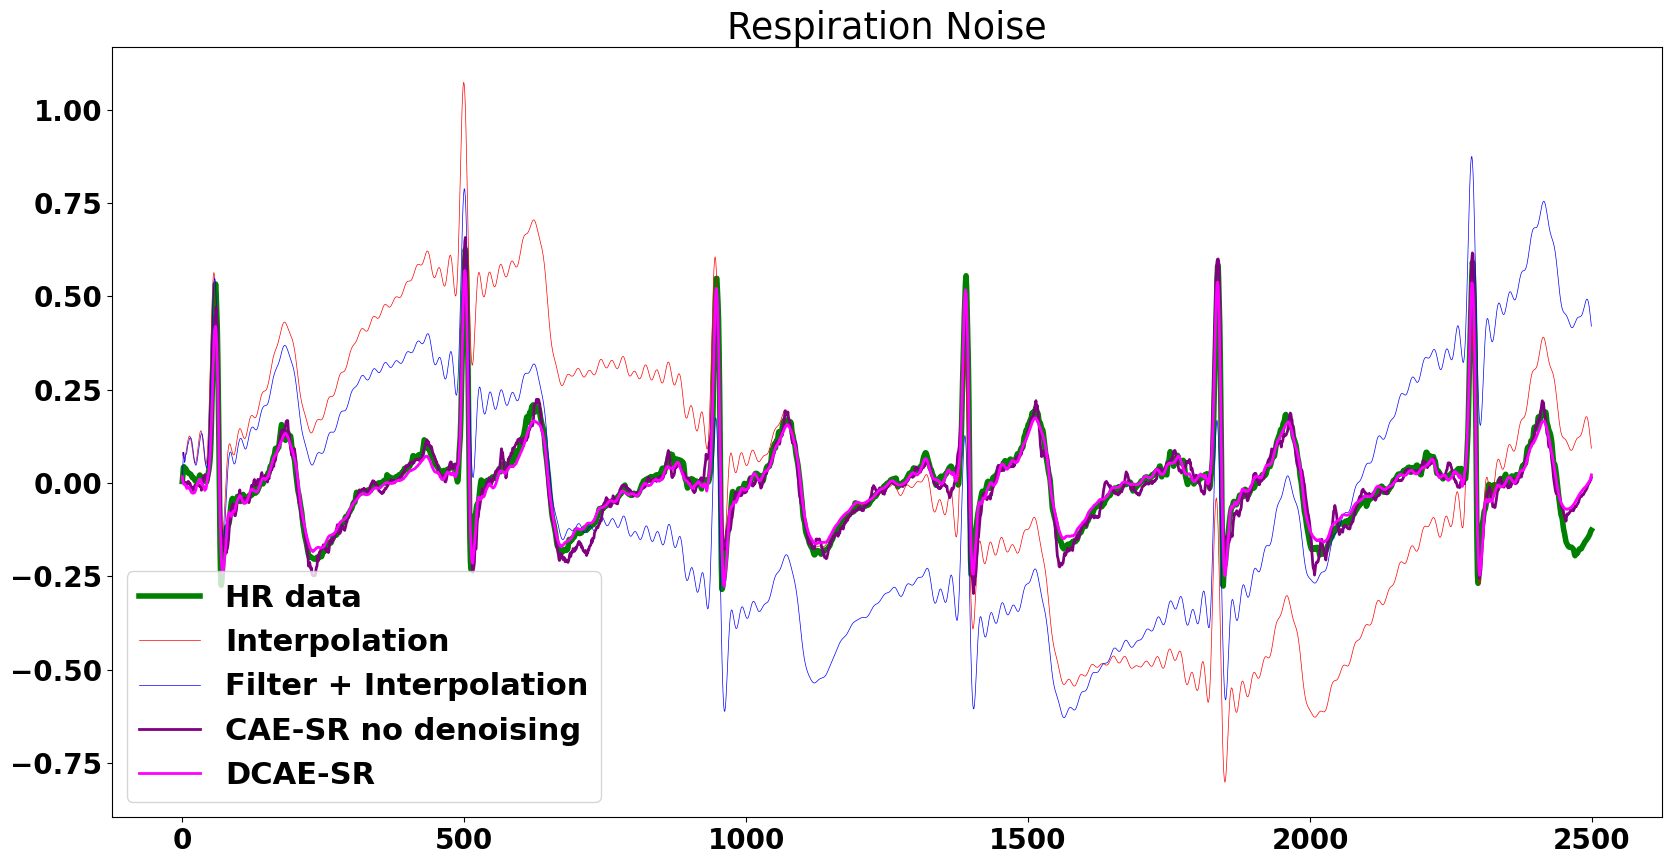

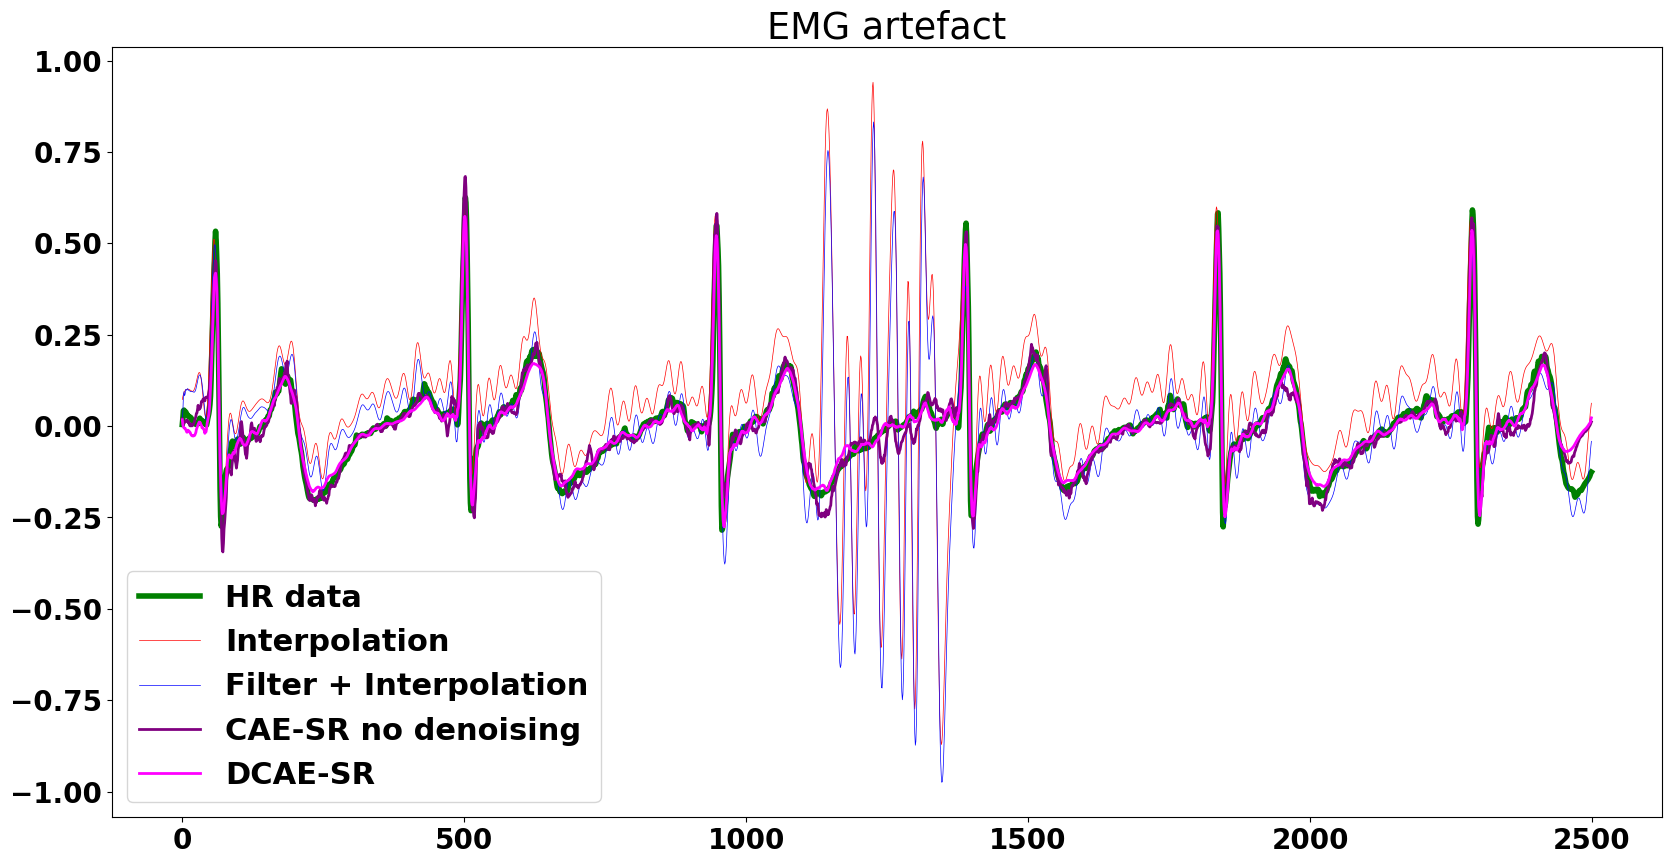

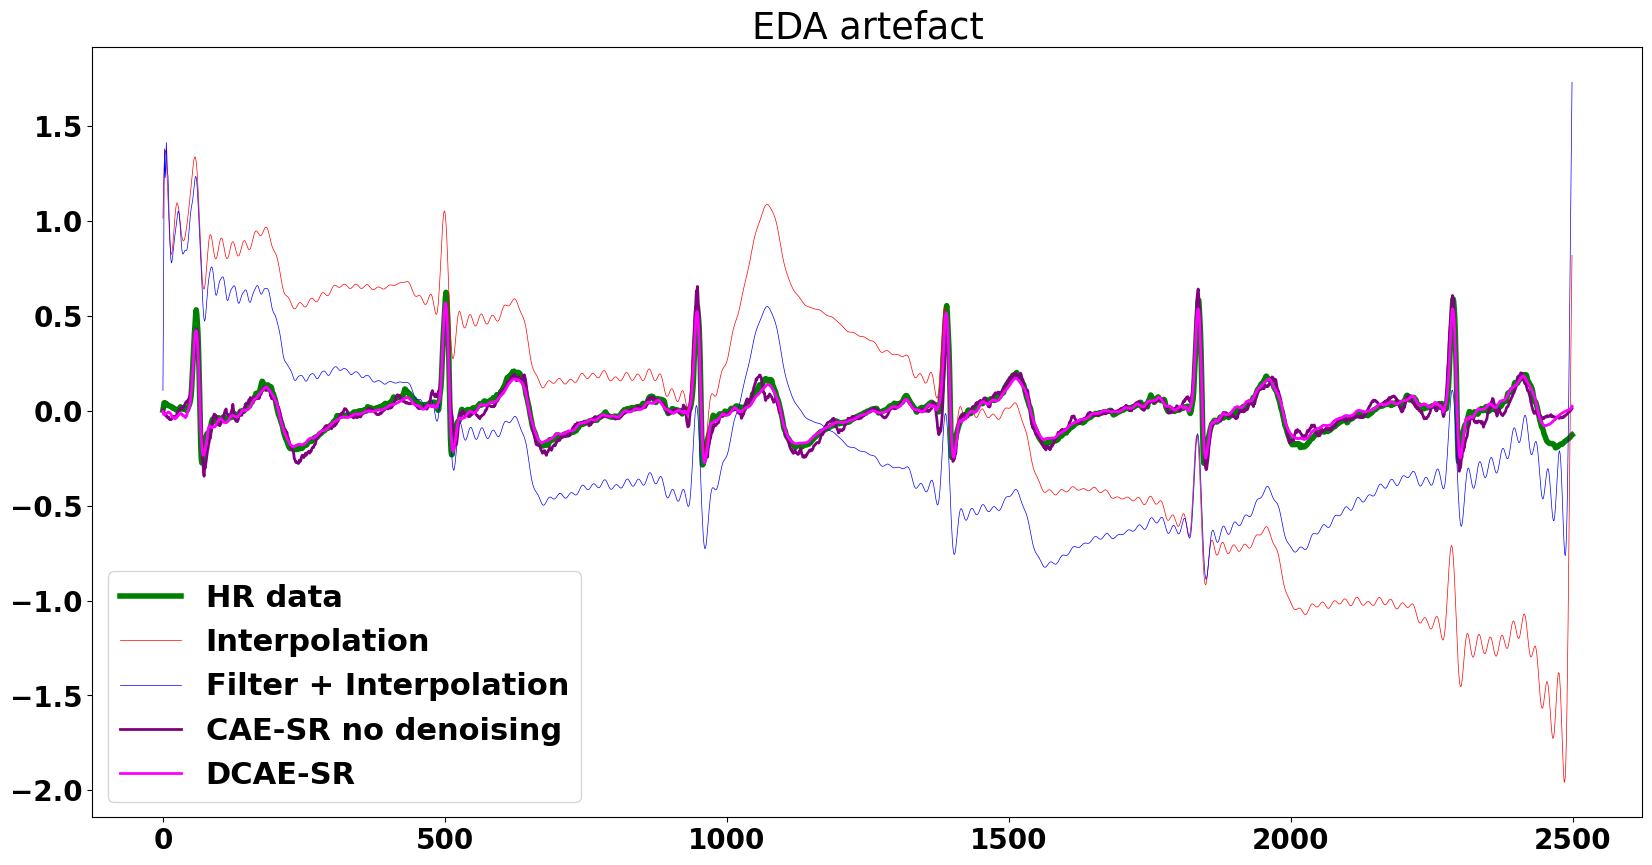

In [49]:
for noise_type, noise_function in noise_functions.items():

    fig = plt.figure(figsize = (20, 10))
    plt.title(noise_type)

    plt.plot(signal_hr[0, :].cpu(), label = "HR data", color = "green", linewidth = 4)

    noisy_signal = noise_function(signal)
    noisy_signal_u = resample_single(noisy_signal, 12, 5*500)
    plt.plot(noisy_signal_u[0, :], label = "Interpolation", color = "red", linewidth = 0.5)

    noisy_signal_u = torch.from_numpy(noisy_signal_u)
    filtered = myfilter_hr(0.05, 150, noisy_signal_u, powerline = 50)
    filtered = resample_single(filtered, 12, 5*500)
    plt.plot(filtered[0, :], label = "Filter + Interpolation", color = "blue", linewidth = 0.5)

    input = torch.unsqueeze(noisy_signal, dim = 0)
    input = torch.unsqueeze(input, dim = 0).float().to(device)
    pred = model([input, None, None, None])
    sr_nd = pred[1].cpu().detach().numpy()
    plt.plot(sr_nd[0, :], label = "CAE-SR no denoising", color = "purple", linewidth = 2)

    pred_d = model_d([input, None, None, None])
    sr_d = pred_d[1].cpu().detach().numpy()
    plt.plot(sr_d[0, :], label = "DCAE-SR", color = "magenta", linewidth = 2)
    plt.legend()

    if noise_type == "EMG artefact":
      fig.savefig("sr_noiseEMG artefact.png", dpi = 600)

In [ ]:
methods = ["filter + interpolation", "interpolation", "wavelets sr", "fft sr", "our proposed (S)"]
functions = [filter_interp, interpolate_sr, wav_sr, fft_sr, sr_our_proposed_onlysignals]
methods = {method:functions[i] for i, method in enumerate(methods)}

In [ ]:
import time
import plotly
from plotly import graph_objects as go

df = pd.DataFrame(columns = columns)
model = model.eval()
model = model.to(device)
colors = ["red", "orange", "yellow", "green", "cyan", "blue"]
fig = go.Figure()
fig1 = go.Figure()
fig2 = go.Figure()

label = "MI"
signals_test = dict_windows_test_lr_n[label]
signals_test_hr = dict_windows_test_hr[label]

for i, (method, function) in enumerate(methods.items()):

    print(method)

    color = colors[i]

    t0 = time.time()
    #compute method sr from low res
    if method == "sparse_representation_sr":
        signals_test_sr = compute_sr(signals_test, function, signals_hr = signals_test_hr)
    else:
        signals_test_sr = compute_sr(signals_test, function)

    if signals_test_sr.ndim == 3:
        signals_test_sr = torch.unsqueeze(signals_test_sr, dim = 1)

    #print(signals_test_sr.shape, signals_test_hr.shape)
    #compute mse
    mses, mse = compute_mse(signals_test_sr, signals_test_hr)
    #compute ssmi
    ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
    #compute psnr
    psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)
    tend = time.time()
    ex_time = round(tend-t0, 3)
    values = [method, mse, ssim, psnr, ex_time]
    df.loc[i] = values

    fig.add_trace(go.Box(
            y=mses,
            name=method,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=color,
            marker_size=2,
            line_width=1)
    )

    fig1.add_trace(go.Box(
            y=ssims,
            name=method,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=color,
            marker_size=2,
            line_width=1)
    )

    fig2.add_trace(go.Box(
            y=psnrs,
            name=method,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=color,
            marker_size=2,
            line_width=1)
    )

    del signals_test_sr
    print("\n")

fig.update_layout(autosize = False, width = 800, height = 800, template = "simple_white")
fig.show()
fig1.update_layout(autosize = False, width = 800, height = 800, template = "simple_white")
fig1.show()
fig2.update_layout(autosize = False, width = 800, height = 800, template = "simple_white")
fig2.show()

filter + interpolation
 1088 / 1088

interpolation
 1088 / 1088

wavelets sr
 1088 / 1088

fft sr
 158 / 1088

<ipython-input-22-4c35bb6045ef>:8: UserWarning:

Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:301.)



 1088 / 1088

our proposed (S)
 1088 / 1088



In [ ]:
def normalize(data):
    from sklearn.preprocessing import MinMaxScaler
    data = np.array(data).reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data[:, 0]

In [ ]:
fig = go.Figure()
fig2 = go.Figure()
fig3 = go.Figure()

methods_list = list(methods.keys())
fig.add_trace(go.Scatterpolar(
          r=mses,
          theta=methods_list,
          fill='toself',
          name="MSE"
    ))
fig2.add_trace(go.Scatterpolar(
          r=ssims,
          theta=methods_list,
          fill='toself',
          name="SSIM"
    ))
fig3.add_trace(go.Scatterpolar(
          r=psnrs,
          theta=methods_list,
          fill='toself',
          name="PSNR"
    ))

fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          #range=[0, 1]
        )),
      showlegend=True
    )

fig.show()
fig2.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0.99, 1]
        )),
      showlegend=True
    )

fig2.show()
fig3.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[20, 30]
        )),
      showlegend=True
    )

fig3.show()

In [ ]:
df

,Method,MSE,SSIM,PSNR,Time (s)
0,filter + interpolation,0.035057,0.985332,15.800933,13.098
1,interpolation,0.185235,0.967726,14.789180,3.791
2,wavelets sr,0.234855,0.980521,9.698363,4.020
3,fft sr,0.065273,0.978821,13.066146,2.672
4,our proposed (S),0.003452,0.998674,25.785413,22.431


In [ ]:
df

,Method,MSE,SSIM,PSNR,Time (s)
0,filter + interpolation,0.035057,0.985332,15.800933,10.277
1,interpolation,0.185235,0.967726,14.789180,2.470
2,scipy resample,0.184350,0.966256,15.034928,194.731
3,wavelets sr,0.234855,0.980521,9.698363,2.397
4,fft sr,0.065273,0.978821,13.066146,1.997
5,our proposed (S),0.005812,0.994214,24.625400,16.238


In [ ]:
df.set_index('Method', inplace = True)
df

,MSE,SSIM,PSNR,Time (s)
Method,,,,
filter + interpolation,0.035057,0.985332,15.800933,10.277
interpolation,0.185235,0.967726,14.789180,2.470
scipy resample,0.184350,0.966256,15.034928,194.731
wavelets sr,0.234855,0.980521,9.698363,2.397
fft sr,0.065273,0.978821,13.066146,1.997
our proposed (S),0.005812,0.994214,24.625400,16.238


In [ ]:
results_path = os.getcwd() + os.sep + "results" + os.sep

In [ ]:
df.to_csv(results_path+"super_resolution_baseline_signalonly.csv")

In [ ]:
def interpolate_width(data, width = 2500, mode = "cubic"):
    width_input = data.shape[-1]
    t_low = np.arange(0, width_input)
    t_high = np.arange(0, width)  #
    f_interp = interpolate.interp1d(t_low, data, kind=mode, fill_value="extrapolate")
    signal_int = f_interp(t_high)
    return signal_int

In [ ]:
import time
import pandas as pd

columns = ["Method", "MSE", "SSIM", "PSNR", "Time (s)"]
model_path = os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_lrhr.pt"
model = torch.load(model_path).to(device)
model.eval()

dfs = {}

for label in labels:
    print(label)
    df_noisy = pd.DataFrame(columns = columns)

    signals_test = dict_windows_test_lr_n[label]
    signals_test_hr = dict_windows_test_hr[label]

    for i, (method, function) in enumerate(methods.items()):

        print(method)

        t0 = time.time()
        #compute method sr from low res
        if method == "sparse_representation_sr":
            signals_test_sr = compute_sr(signals_test, function, signals_hr = signals_test_hr)
        else:
            signals_test_sr = compute_sr(signals_test, function)

        if signals_test_sr.ndim == 3:
            signals_test_sr = torch.unsqueeze(signals_test_sr, dim = 1)

        #compute mse
        mses, mse = compute_mse(signals_test_sr, signals_test_hr)
        #compute ssmi
        ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
        #compute psnr
        psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)
        tend = time.time()
        ex_time = round(tend-t0, 3)
        values = [method, mse, ssim, psnr, ex_time]
        df_noisy.loc[i] = values
        print("\n")

    dfs[label] = df_noisy
    clear_output()

In [ ]:
for label, df_noisy in dfs.items():
    df_noisy.set_index('Method', inplace = True)

In [ ]:
df_noisy["MSE"][-1]

0.002859158224868298

In [ ]:
mses = []
psnrs = []
ssims = []
rmses = []

for label, df_noisy in dfs.items():
  mse = df_noisy["MSE"][-1]
  rmse = np.sqrt(mse)
  psnr = df_noisy["PSNR"][-1]
  ssim = df_noisy["SSIM"][-1]
  mses.append(mse)
  rmses.append(rmse)
  psnrs.append(psnr)
  ssims.append(ssim)

np.mean(mses), np.mean(rmses), np.mean(psnrs), np.mean(ssims)

(0.0042642345101761, 0.0645159647672, 25.444257344905953, 0.9984245303578154)

In [ ]:
dfs["CD"]

,MSE,SSIM,PSNR,Time (s)
Method,,,,
filter + interpolation,0.053439,0.983033,14.677789,5.743
interpolation,0.184918,0.970342,15.364292,1.576
wavelets sr,0.247137,0.981805,9.449737,1.504
fft sr,0.098162,0.974577,11.915377,1.196
our proposed (S),0.005789,0.997935,25.025352,9.007


In [ ]:
dfs["NORM"]

,MSE,SSIM,PSNR,Time (s)
Method,,,,
filter + interpolation,0.030185,0.984939,16.327958,17.724
interpolation,0.183834,0.962878,14.920586,4.336
scipy resample,0.182645,0.960624,15.286844,370.491
wavelets sr,0.223409,0.977775,10.198231,4.273
fft sr,0.052118,0.975099,13.684379,3.625
our proposed (S),0.003841,0.995544,25.680677,27.794


In [ ]:
dfs["MI"]

,MSE,SSIM,PSNR,Time (s)
Method,,,,
filter + interpolation,0.035057,0.985332,15.800933,10.191
interpolation,0.185235,0.967726,14.789180,2.525
scipy resample,0.184350,0.966256,15.034928,209.104
wavelets sr,0.234855,0.980521,9.698363,2.426
fft sr,0.065273,0.978821,13.066146,1.989
our proposed (S),0.005812,0.994214,24.625400,16.378


In [ ]:
dfs["STTC"]

,MSE,SSIM,PSNR,Time (s)
Method,,,,
filter + interpolation,0.029562,0.987253,16.655265,5.206
interpolation,0.179424,0.965623,14.542617,1.291
scipy resample,0.178289,0.962666,14.871421,108.834
wavelets sr,0.223839,0.979463,9.938540,1.247
fft sr,0.055690,0.977418,13.659052,1.041
our proposed (S),0.005251,0.994452,25.095407,8.366


In [ ]:
dfs["HYP"]

,MSE,SSIM,PSNR,Time (s)
Method,,,,
filter + interpolation,0.045788,0.988266,14.351607,2.142
interpolation,0.181322,0.974269,13.919638,0.434
scipy resample,0.179013,0.973071,14.272197,46.755
wavelets sr,0.254005,0.984661,8.509058,0.544
fft sr,0.097376,0.975146,10.919133,0.446
our proposed (S),0.013945,0.987274,20.574396,3.725


In [ ]:
dfs["CD"]

,MSE,SSIM,PSNR,Time (s)
Method,,,,
filter + interpolation,0.053439,0.983033,14.677789,4.453
interpolation,0.184918,0.970342,15.364292,1.090
scipy resample,0.184019,0.967566,15.636939,94.084
wavelets sr,0.247137,0.981805,9.449737,1.107
fft sr,0.098162,0.974577,11.915377,0.890
our proposed (S),0.013396,0.988932,23.077495,7.241


In [ ]:
mses = [0.013396, 0.013945, 0.005251, 0.005812, 0.003841]
mse_mean = np.mean(mses)
rmse = np.sqrt(mse_mean)
mse_mean, rmse

(0.008449, 0.09191844211038391)

In [ ]:
labels

['MI', 'STTC', 'CD', 'HYP', 'NORM']

In [ ]:
dfs["MI"].to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n & MSE & SSIM & PSNR & Time (s) \\\\\nMethod &  &  &  &  \\\\\n\\midrule\nfilter + interpolation & 0.035057 & 0.985332 & 15.800933 & 10.867000 \\\\\ninterpolation & 0.185235 & 0.967726 & 14.789180 & 2.617000 \\\\\nscipy resample & 0.184350 & 0.966256 & 15.034928 & 153.949000 \\\\\nwavelets sr & 0.234855 & 0.980521 & 9.698363 & 2.561000 \\\\\niterative back projection & 0.042959 & 0.000000 & 14.867909 & 3.800000 \\\\\nfft sr & 0.065273 & 0.978821 & 13.066146 & 2.035000 \\\\\nnon-uniform sr & 0.042959 & 0.000000 & 14.867909 & 2.913000 \\\\\nour proposed (S) & 0.005830 & 0.993867 & 24.546035 & 16.955000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
results_path = os.getcwd() + os.sep + "results" + os.sep
dfs["MI"].to_csv(results_path+"super_resolution_baseline_signalonly_noisy.csv")

In [ ]:
!ls

 activationmap_superresolution_labelCD_ch0-1_noised.png
 activationmap_superresolution_labelCD_nonoise.png
 activationmap_superresolution_labelCD.png
 activationmap_superresolution_labelHYP_ch0-1_noised.png
 activationmap_superresolution_labelHYP_nonoise.png
 activationmap_superresolution_labelHYP.png
 activationmap_superresolution_labelMI_ch0-1_noised.png
 activationmap_superresolution_labelMI_nonoise.png
 activationmap_superresolution_labelMI.png
 activationmap_superresolution_labelNORM_ch0-1_noised.png
'activationmap_superresolution_labelNORM_idx10_noiseEDA artifact.png'
'activationmap_superresolution_labelNORM_idx10_noiseEMG artifact.png'
 activationmap_superresolution_labelNORM_idx10_noiseNO.png
'activationmap_superresolution_labelNORM_idx10_noiseRespiration Noise.png'
 activationmap_superresolution_labelNORM_nonoise.png
 activationmap_superresolution_labelNORM.png
 activationmap_superresolution_labelSTTC_ch0-1_noised.png
 activationmap_superresolution_labelSTTC_nonoise.png
 activ

In [ ]:
os.getcwd() + os.sep + "models" + os.sep

'/content/drive/MyDrive/Colab Notebooks/ECG_SuperResolution/models/'

In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/ECG_SuperResolution/models/"

model_2_ab1.zip		 model_2_denoising_lrhr.pt     model_2_denoising.pt	    model_2.pt
model_2_ab2.zip		 model_2_denoising_lrhr_v2.pt  model_2_nodenoising_nosr.pt
model_2_denoising_hr.pt  model_2_denoising_nosr.pt     model_2_nodenoising.pt


/usr/local/lib/python3.10/dist-packages/torch/serialization.py:1438: UserWarning: This figure was saved with matplotlib version 3.8.0 and is unlikely to function correctly.
  result = unpickler.load()


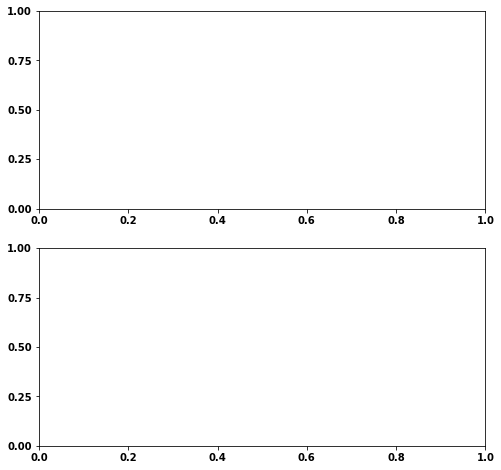

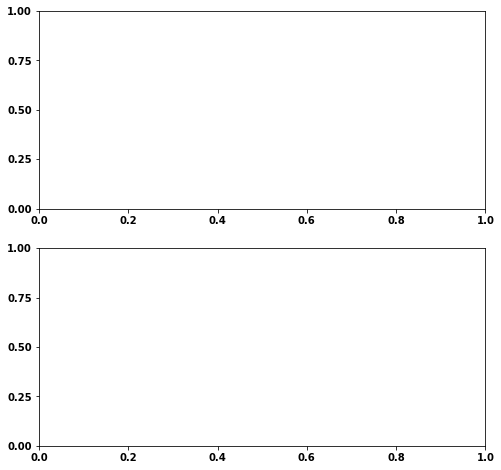

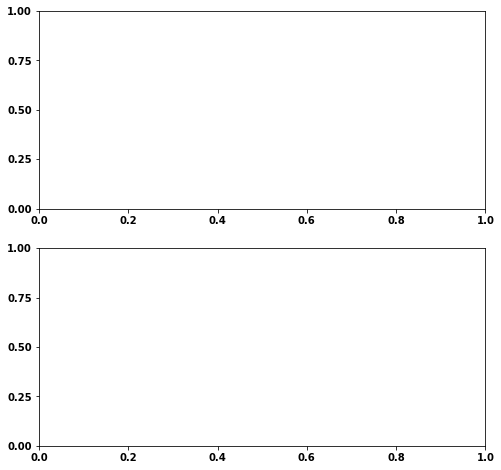

In [ ]:
models = {
          "DCAE": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_lrhr.pt").to(device),
          "CAE": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_nodenoising.pt").to(device)
}

In [ ]:
df = pd.DataFrame(columns = ["model", "Noise", "MSE", "SSMI", "PSNR"])
i = 0
noise = [True, False]
label = "MI"

signals_test_hr = dict_windows_test_hr[label]

for name, model in models.items():
    for noise_presence in noise:

        if noise_presence:
            signals_test = dict_windows_test_lr_n[label]
        else:
            signals_test = dict_windows_test_lr[label]

        signals_test_sr = compute_sr(signals_test, sr_our_proposed_onlysignals)

        #compute mse
        mses, mse  = compute_mse(signals_test_sr, signals_test_hr)
        #compute ssmi
        ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
        #compute psnr
        psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)

        values = [name, noise_presence, mse, ssim, psnr]
        df.loc[i] = values
        i+=1

In [ ]:
df

In [ ]:
df

,model,Noise,MSE,SSMI,PSNR
0,DCAE,True,0.005812,0.994214,24.625400
1,DCAE,False,0.005440,0.994647,25.206207
2,CAE,True,0.068613,0.940977,16.709214
3,CAE,False,0.005644,0.994154,24.770750


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/ECG_SuperResolution/models/"

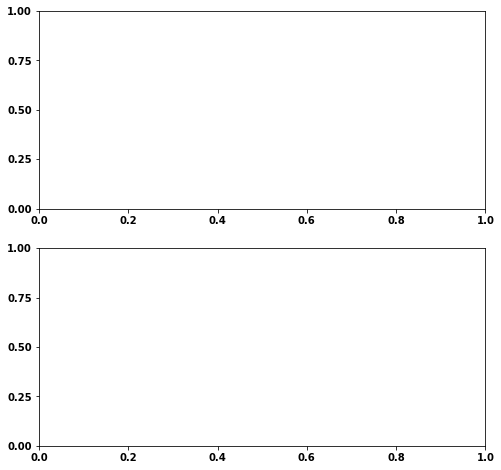

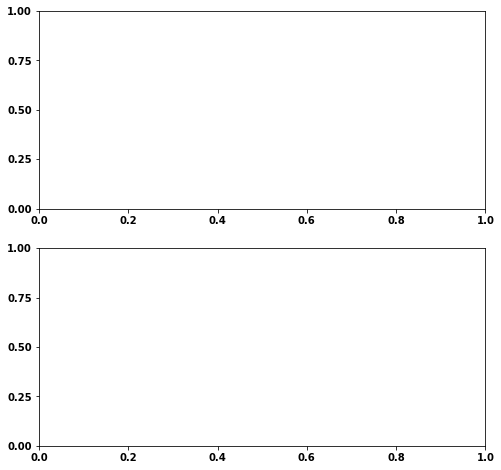

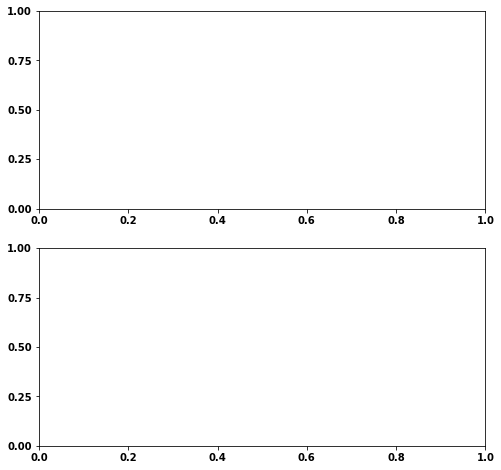

In [ ]:
models = {"HR": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_hr.pt").to(device),
          "LR + HR": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_lrhr.pt").to(device)
}

In [ ]:
columns = ["Loss Type", "MSE", "SSIM", "PSNR"]
df = pd.DataFrame(columns = columns)

i = 0
label = "MI"

signals_test_hr = dict_windows_test_hr[label]

for loss_type, model in models.items():

    signals_test = dict_windows_test_lr_n[label]

    signals_test_sr = compute_sr(signals_test, sr_our_proposed_onlysignals)

    #compute mse
    mses, mse = compute_mse(signals_test_sr, signals_test_hr)
    #compute ssmi
    ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
    #compute psnr
    psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)

    values = [loss_type, mse, ssim, psnr]
    df.loc[i] = values
    i+=1

df

 1088 / 1088

,Loss Type,MSE,SSIM,PSNR
0,HR,0.006947,0.993461,23.449732
1,LR + HR,0.005812,0.994214,24.625400


In [ ]:
#TO DO: DIFFERENT FILTERING + CUBIC INTERPOLATION vs OURS

In [ ]:
columns = ["Method", "MSE", "SSIM", "PSNR", "Time (s)"]
df = pd.DataFrame(columns = columns)
df.head()

,Method,MSE,SSIM,PSNR,Time (s)


In [ ]:
def mov_avg_int(data, nchs = 12, window_size = 2):

    if data.ndim == 3:
        data = data[0]
    denoised_ecg = []
    for ch in range(nchs):
        data_ch = data[ch, :]
        cumsum = np.cumsum(np.insert(data_ch, 0, 0))
        denoised_ecg.append((cumsum[window_size:] - cumsum[:-window_size]) / window_size)
    denoised_ecg = np.array(denoised_ecg)
    #print(denoised_ecg.shape)
    denoised_ecg = interpolate_width(denoised_ecg, width=250)
    denoised_ecg = interpolate_sr(denoised_ecg)
    #print(denoised_ecg.shape)
    return denoised_ecg

In [ ]:
def medianfilt_int(ecg_signal, window_size = 4, nchs = 12):

    if ecg_signal.ndim == 3:
        ecg_signal = ecg_signal[0]
    denoised_ecg = np.zeros_like(ecg_signal)

    for ch in range(nchs):
        ecg_signal_ch = ecg_signal[ch, :]
        for i in range(len(ecg_signal_ch)):
            start = max(0, i - window_size // 2)
            end = min(len(ecg_signal), i + window_size // 2 + 1)
            denoised_ecg[ch, i] = np.median(ecg_signal[ch, start:end])
    denoised_ecg = np.array(denoised_ecg)
    denoised_ecg = interpolate_width(denoised_ecg, width=250)
    denoised_ecg = interpolate_sr(denoised_ecg)
    return denoised_ecg

In [ ]:
import pywt

def wav_int(ecg_signal, nchs = 12, wavelet='db4', level=3):

    if ecg_signal.ndim == 3:
        ecg_signal = ecg_signal[0]

    denoised_ecg = []
    for ch in range(nchs):

        #print(ecg_signal.shape)
        ecg_signal_ch = ecg_signal[ch, :]
        # Decompose the signal using wavelet transform
        coeffs = pywt.wavedec(ecg_signal_ch, wavelet, level=level)

        # Set a threshold for coefficient values
        threshold = 0.2 * max(coeffs[1])

        # Threshold the wavelet coefficients
        coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

        # Reconstruct the denoised signal
        denoised_ecg.append(pywt.waverec(coeffs, wavelet))

    denoised_ecg = np.array(denoised_ecg)
    denoised_ecg = interpolate_sr(denoised_ecg)
    return denoised_ecg

In [ ]:
from PyEMD import EMD

def emd_int(ecg_signal, nchs = 12):

    if ecg_signal.ndim == 3:
        ecg_signal = ecg_signal[0]

    denoised_ecg = []
    for ch in range(nchs):
        emd = EMD()
        imfs = emd(ecg_signal[ch, :])
        denoised_ecg.append(np.sum(imfs[:-1], axis=0))  # Sum of IMFs excluding the residue

    denoised_ecg = np.array(denoised_ecg)
    denoised_ecg = interpolate_sr(denoised_ecg)
    return denoised_ecg


In [ ]:
def fft_int(ecg_signal, nchs = 12):
    pass

In [ ]:
methods = ["bandpass filter + interpolation", "wavelet filter + interpolation", "emd filter + interpolation", "median filter + interpolation", "moving average + interpolation", "DCAE-time"]#
functions = [filter_interp, wav_int, emd_int, mov_avg_int, medianfilt_int, mov_avg_int, sr_our_proposed_onlysignals]#  #to add fft_int
methods = {method:functions[i] for i, method in enumerate(methods)}

In [ ]:
label = "MI"
signals_test = dict_windows_test_lr_n[label]
signals_test_hr = dict_windows_test_hr[label]

In [ ]:
methods

{'bandpass filter + interpolation': <function __main__.filter_interp(signals, nchs=12)>,
 'wavelet filter + interpolation': <function __main__.wav_int(ecg_signal, nchs=12, wavelet='db4', level=3)>,
 'emd filter + interpolation': <function __main__.emd_int(ecg_signal, nchs=12)>,
 'median filter + interpolation': <function __main__.mov_avg_int(data, nchs=12, window_size=2)>,
 'moving average + interpolation': <function __main__.medianfilt_int(ecg_signal, window_size=4, nchs=12)>,
 'DCAE-time': <function __main__.mov_avg_int(data, nchs=12, window_size=2)>}

In [ ]:
function = methods["moving average + interpolation"]
signals_test_sr = compute_sr(signals_test, function)
if signals_test_sr.ndim == 3:
    signals_test_sr = torch.unsqueeze(signals_test_sr, dim = 1)

mses, mse = compute_mse(signals_test_sr, signals_test_hr)
mse

 2 / 1088

C:\Users\Utente\Schrodinger\PyMOL2\envs\Cambridge\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

C:\Users\Utente\Schrodinger\PyMOL2\envs\Cambridge\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning:

invalid value encountered in divide



 1088 / 1088

nan

In [ ]:
import time

columns = ["Method", "MSE", "SSIM", "PSNR", "Time (s)"]
df = pd.DataFrame(columns = columns)
model = models["LR + HR"]
model = model.eval()
model = model.to(device)

label = "MI"

signals_test = dict_windows_test_lr_n[label]
signals_test_hr = dict_windows_test_hr[label]
for i, (method, function) in enumerate(methods.items()):

    print(method, function)

    t0 = time.time()
    #compute method sr from low res

    signals_test_sr = compute_sr(signals_test, function)

    if signals_test_sr.ndim == 3:
        signals_test_sr = torch.unsqueeze(signals_test_sr, dim = 1)

    #print(signals_test_sr.shape, signals_test_hr.shape)
    #compute mse
    mses, mse = compute_mse(signals_test_sr, signals_test_hr)
    #compute ssmi
    ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
    #compute psnr
    psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)
    tend = time.time()
    ex_time = round(tend-t0, 3)
    values = [method, mse, ssim, psnr, ex_time]
    df.loc[i] = values

    del signals_test_sr
    print("\n")

df

bandpass filter + interpolation <function filter_interp at 0x0000019F9A8BA5C0>
 1088 / 1088

wavelet filter + interpolation <function wav_int at 0x000001A08776B2E0>
 1088 / 1088

emd filter + interpolation <function emd_int at 0x000001A018ABFEC0>
 27 / 1088


KeyboardInterrupt



In [ ]:
#change bp freq

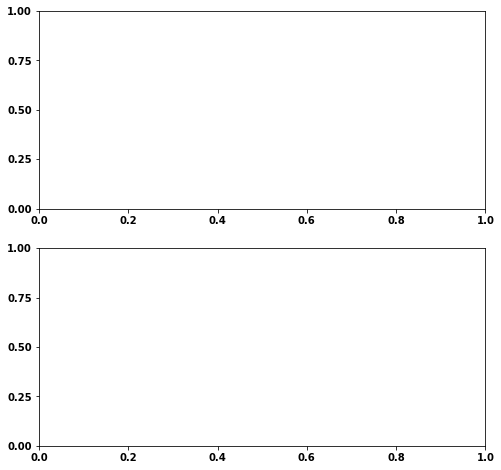

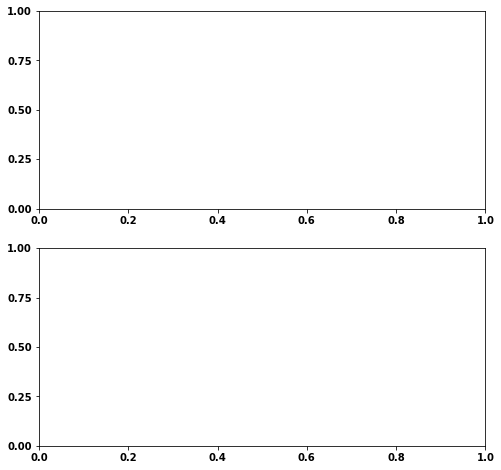

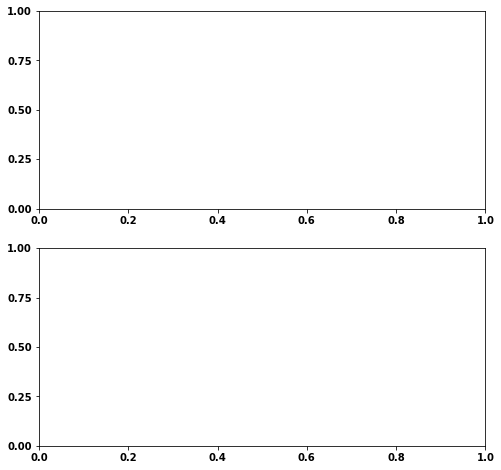

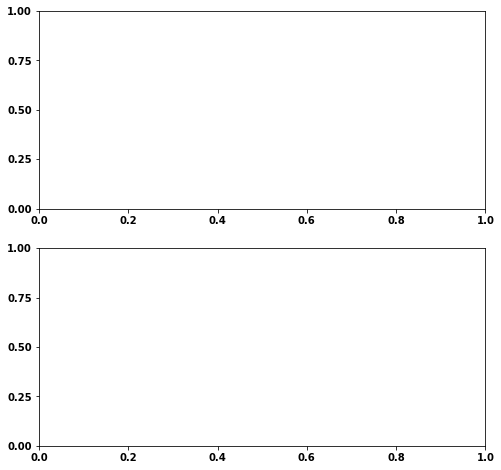

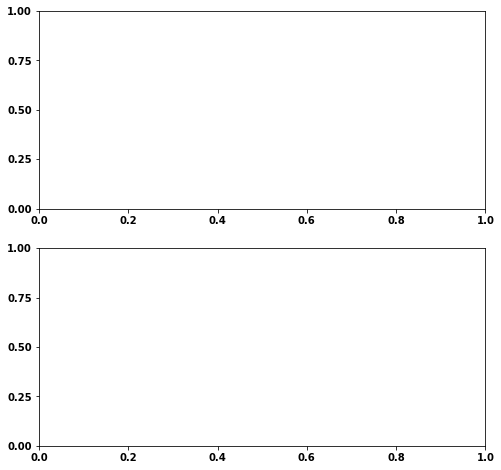

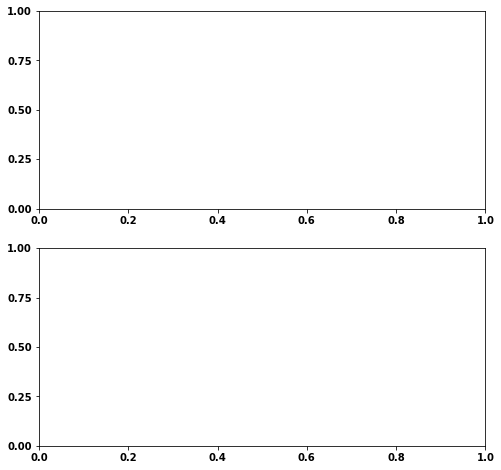

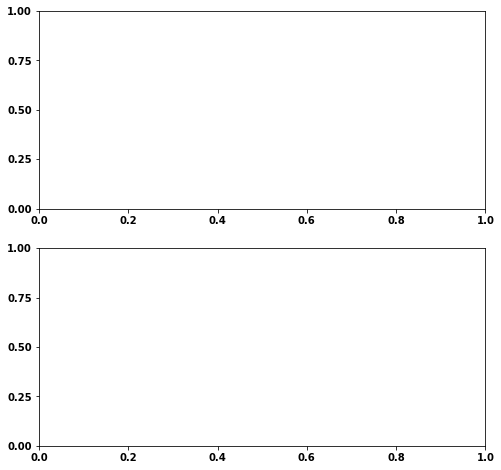

In [ ]:
models = {"DCAE_noSR": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_nosr.pt").to(device),
          "DCAE_SR": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_lrhr.pt").to(device),
          "CAE_noSR": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_nodenoising_nosr.pt").to(device),
          "CAE_SR": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_nodenoising.pt").to(device)
}

In [ ]:
def compute_nosr(lr_datas, model):

    lr_datas = lr_datas.to(device)
    sr_datas = []
    n = len(lr_datas)
    for i, lr_data in enumerate(lr_datas):
        print(i+1, "/", n, end = "\r")
        pred = model([lr_data, None, None, None])
        rec = pred[0]
        sr_data = interpolate_sr(rec.cpu().detach().numpy())
        sr_datas.append(sr_data)
    sr_datas = torch.from_numpy(np.array(sr_datas)).to(device)
    return sr_datas

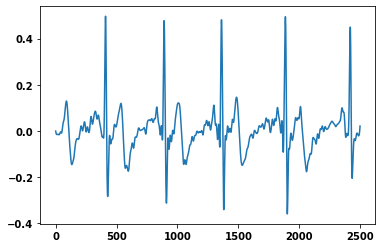

In [ ]:
lr_data = dict_windows_test_lr_n[label][0]
pred = model([lr_data, None, None, None])
rec = pred[0].cpu().detach().numpy()
sr_data = interpolate_sr(rec)
plt.plot(sr_data[0, :])

In [ ]:
df = pd.DataFrame(columns = ["Denoising", "Super Resolution", "MSE", "SSMI", "PSNR"])
i = 0
label = "MI"

signals_test_hr = dict_windows_test_hr[label]

for name, model in models.items():
    signals_test = dict_windows_test_lr_n[label]
    if "D" in name:
        denoising = "V"
        model.denoising = True
    else:
        denoising = "X"
        model.denoising = False
    if "noSR" in name:
        super_resolution = "X"
    else:
        super_resolution = "V"

    if super_resolution == "V":
        signals_test_sr = compute_sr(signals_test, sr_our_proposed_onlysignals)
    else:
        signals_test_sr = compute_nosr(signals_test, model)


    #compute mse
    mses, mse  = compute_mse(signals_test_sr, signals_test_hr)
    #compute ssmi
    ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
    #compute psnr
    psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)

    values = [denoising, super_resolution, mse, ssim, psnr]
    df.loc[i] = values
    i+=1

C:\Users\Utente\AppData\Local\Temp\ipykernel_1476\917586708.py:7: UserWarning: Using a target size (torch.Size([1, 12, 2500])) that is different to the input size (torch.Size([12, 2500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(signal_sr, signal_hr)


C:\Users\Utente\AppData\Local\Temp\ipykernel_1476\917586708.py:7: UserWarning: Using a target size (torch.Size([1, 12, 2500])) that is different to the input size (torch.Size([12, 2500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(signal_sr, signal_hr)


 1088 / 1088

In [ ]:
df

,Denoising,Super Resolution,MSE,SSMI,PSNR
0,V,X,0.007329,0.993879,22.996780
1,V,V,0.005812,0.994214,24.625400
2,X,X,0.136264,0.916896,14.170322
3,X,V,0.068613,0.940977,16.709214


In [ ]:
len(methods.keys())

6

In [ ]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = "24"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = "24"

In [ ]:
good = list(df_noisy[df_noisy["SSIM"] != 0.0].index)
good

['filter + interpolation',
 'interpolation',
 'scipy resample',
 'wavelets sr',
 'fft sr',
 'our proposed (S)']

In [ ]:
"""
idx = 520
nchs = 12
ch = 0
label = "MI"
lr_data = dict_windows_test_lr_n[label][idx][ch].cpu()#dict_windows_test_lr_n[label][idx][ch].cpu()
hr_data = dict_windows_test_hr[label][idx][ch].cpu()
fig = plt.figure(figsize = (40, 20))
model = models["LR + HR"]

colors = ["green", "blue", "black", "red", "orange", "red"]
skips = ["fft sr"]
while True:
    if lr_data.ndim == 4:
        break
    else:
        lr_data = torch.unsqueeze(lr_data, dim = 0)

while True:
    if hr_data.ndim == 4:
        break
    else:
        hr_data = torch.unsqueeze(hr_data, dim = 0)

i = 0
plt.plot(hr_data[0, 0, ch, :], color = colors[0], label = "HR data", linewidth = 4)
i+=1

for (method, function) in methods.items():

    print(method)
    if method in good and method not in skips:
        print(lr_data.shape, hr_data.shape)
        #compute method sr from low res
        if method == "sparse_representation_sr":
            sr_data = compute_sr(lr_data, function, signals_hr = hr_data)
        else:
            sr_data = compute_sr(lr_data, function)

        if sr_data.ndim == 3:
            sr_data = torch.unsqueeze(sr_data, dim = 1)

        color = colors[i]
        if method == "our proposed (S)":
            linewidth = 3
        elif method == "filter + interpolation":
            linewidth = 2
        else:
            linewidth = 0.5
        plt.plot(sr_data[0, 0, ch, :], color = color, label = method, linewidth = linewidth)
        i+=1
plt.legend()
"""

'\nidx = 520\nnchs = 12\nch = 0\nlabel = "MI"\nlr_data = dict_windows_test_lr_n[label][idx][ch].cpu()#dict_windows_test_lr_n[label][idx][ch].cpu()\nhr_data = dict_windows_test_hr[label][idx][ch].cpu()\nfig = plt.figure(figsize = (40, 20))\nmodel = models["LR + HR"]\n\ncolors = ["green", "blue", "black", "red", "orange", "red"]\nskips = ["fft sr"]\nwhile True:\n    if lr_data.ndim == 4:\n        break\n    else:\n        lr_data = torch.unsqueeze(lr_data, dim = 0)\n\nwhile True:\n    if hr_data.ndim == 4:\n        break\n    else:\n        hr_data = torch.unsqueeze(hr_data, dim = 0)\n\ni = 0\nplt.plot(hr_data[0, 0, ch, :], color = colors[0], label = "HR data", linewidth = 4)\ni+=1\n\nfor (method, function) in methods.items():\n\n    print(method)\n    if method in good and method not in skips:\n        print(lr_data.shape, hr_data.shape)\n        #compute method sr from low res\n        if method == "sparse_representation_sr":\n            sr_data = compute_sr(lr_data, function, signals

In [ ]:
#fig.savefig("sr_EMGnoise_comparison.png", dpi=600)

In [ ]:
import scipy
def resample_signal(data, fs=50, nchs = 12, fin = 50):

    data = data.cpu()

    secs = data.shape[-1]/(fin)
    size = int(fs*secs)

    resampled_data = []
    for ch in range(nchs):
        temp = scipy.signal.resample(x=data[ch, :].detach().numpy(), num=size)
        resampled_data.append(torch.from_numpy(temp))

    resampled_data = torch.stack(resampled_data)

    return resampled_data

import torch.nn.functional as F
def check_super_resolution_quality(not_resampled_data, super_resolution_data):

    mse_errors = []
    for i, data in enumerate(not_resampled_data):
        print(i+1, "/", len(not_resampled_data), end="\r")
        sr_data = super_resolution_data[i]
        error = F.mse_loss(data, sr_data).to("cpu")
        mse_errors.append(error.item())
        del error
        del sr_data
        del data
    mean_mse = np.mean(mse_errors)
    return mean_mse, mse_errors

def validate_single_channel(dict_windows_test, dict_windows_test_hr, label, model, channel = None, upsample = False):

    super_resolution_windows = []

    device = "cpu"
    model = model.to("cpu")
    model.eval()

    testing_data = dict_windows_test[label].to("cpu")
    testing_data_hr = dict_windows_test_hr[label].to("cpu")
    for i, window in enumerate(testing_data):
        print("{}/{}".format(i+1, len(testing_data)), end="\r")
        if channel is not None:
            window = window[:, channel, :]
        window = torch.unsqueeze(window, dim = 0).to(device)
        pred = model([window, None, None, None])
        del window

        if not upsample:
            sr_data = pred[1]
            sr_data = torch.unsqueeze(sr_data, dim = 0)
        else:
            rec_data = pred[0]
            #rec_data = torch.unsqueeze(rec_data, dim = 0)
            sr_data = resample_signal(rec_data, fs = 500, fin = 50)
            del rec_data

        del pred
        super_resolution_windows.append(sr_data.to("cpu"))
        del sr_data

    del testing_data
    del model
    gc.collect()
    torch.cuda.empty_cache()
    loss, losses = check_super_resolution_quality(testing_data_hr, super_resolution_windows)
    #super_resolution_windows = [window.to("cpu") for window in super_resolution_windows]
    del testing_data_hr
    return loss, losses, super_resolution_windows

In [ ]:
import pandas as pd

columns = ["Superclass", "Min MSE", "Max MSE", "Mean MSE(+/-STD)"]
df_all = pd.DataFrame(columns = columns)
df_all.head()

losses_label = {}
for i, label in enumerate(labels):

    print(label)
    loss, losses, sr_windows = validate_single_channel(dict_windows_test_lr_n, dict_windows_test_hr, label, model, channel = None)
    min_ = round(np.min(losses), 5)
    max_ = round(np.max(losses), 5)
    mean_ = round(np.mean(losses), 5)
    std_ = round(np.std(losses), 5)
    values = [label, min_, max_, "{}(+/-){}".format(mean_, std_)]
    df_all.loc[i] = values

    del sr_windows
    losses_label[label] = losses
    print("\n")

MI
1088 / 1088

STTC
568 / 568

CD
490 / 490

HYP
244 / 244

NORM
1926 / 1926



In [ ]:
import plotly
import plotly.graph_objects as go


fig = go.Figure()

colors = ["red", "orange", "yellow", "green", "cyan"]
for i, (label, losses) in enumerate(losses_label.items()):
    print(label)
    c = colors[i]
    fig.add_trace(go.Box(y=losses,
            boxpoints='suspectedoutliers', # can also be outliers, or suspectedoutliers, or False
            jitter = 0.2, # add some jitter for a better separation between points
            pointpos= -0.5, # relative position of points wrt box
            name = "<b>"+label+"</b>",
            line_width = 0.5,
            line_color='black',
            fillcolor = c
        )
    )

fig.update_layout(autosize = False, width = 1600, height = 800, template = "simple_white", legend = dict(font = dict(size = 24)), font=dict(size=24), yaxis = dict(tickfont = dict(size=24)))
fig.show()

MI
STTC
CD
HYP
NORM


In [ ]:
sort_idxs

array([475, 223, 632, ..., 939,  88, 399])

In [ ]:
label = "CD"
losses = losses_label[label]
sort_idxs = np.argsort(losses)[::-1]
maxloss_idx = losses[sort_idxs[0]]
maxloss_idx

0.5076810121536255

In [ ]:
maxloss_idx

0.5076810121536255

In [ ]:
channels = ["I", "II", "III", "aVL", "aVR", "aVF", "V1", "V2", "V3", "V4", "V5", "V6" ]
channels_map = {idx: channel for idx, channel in enumerate(channels)}

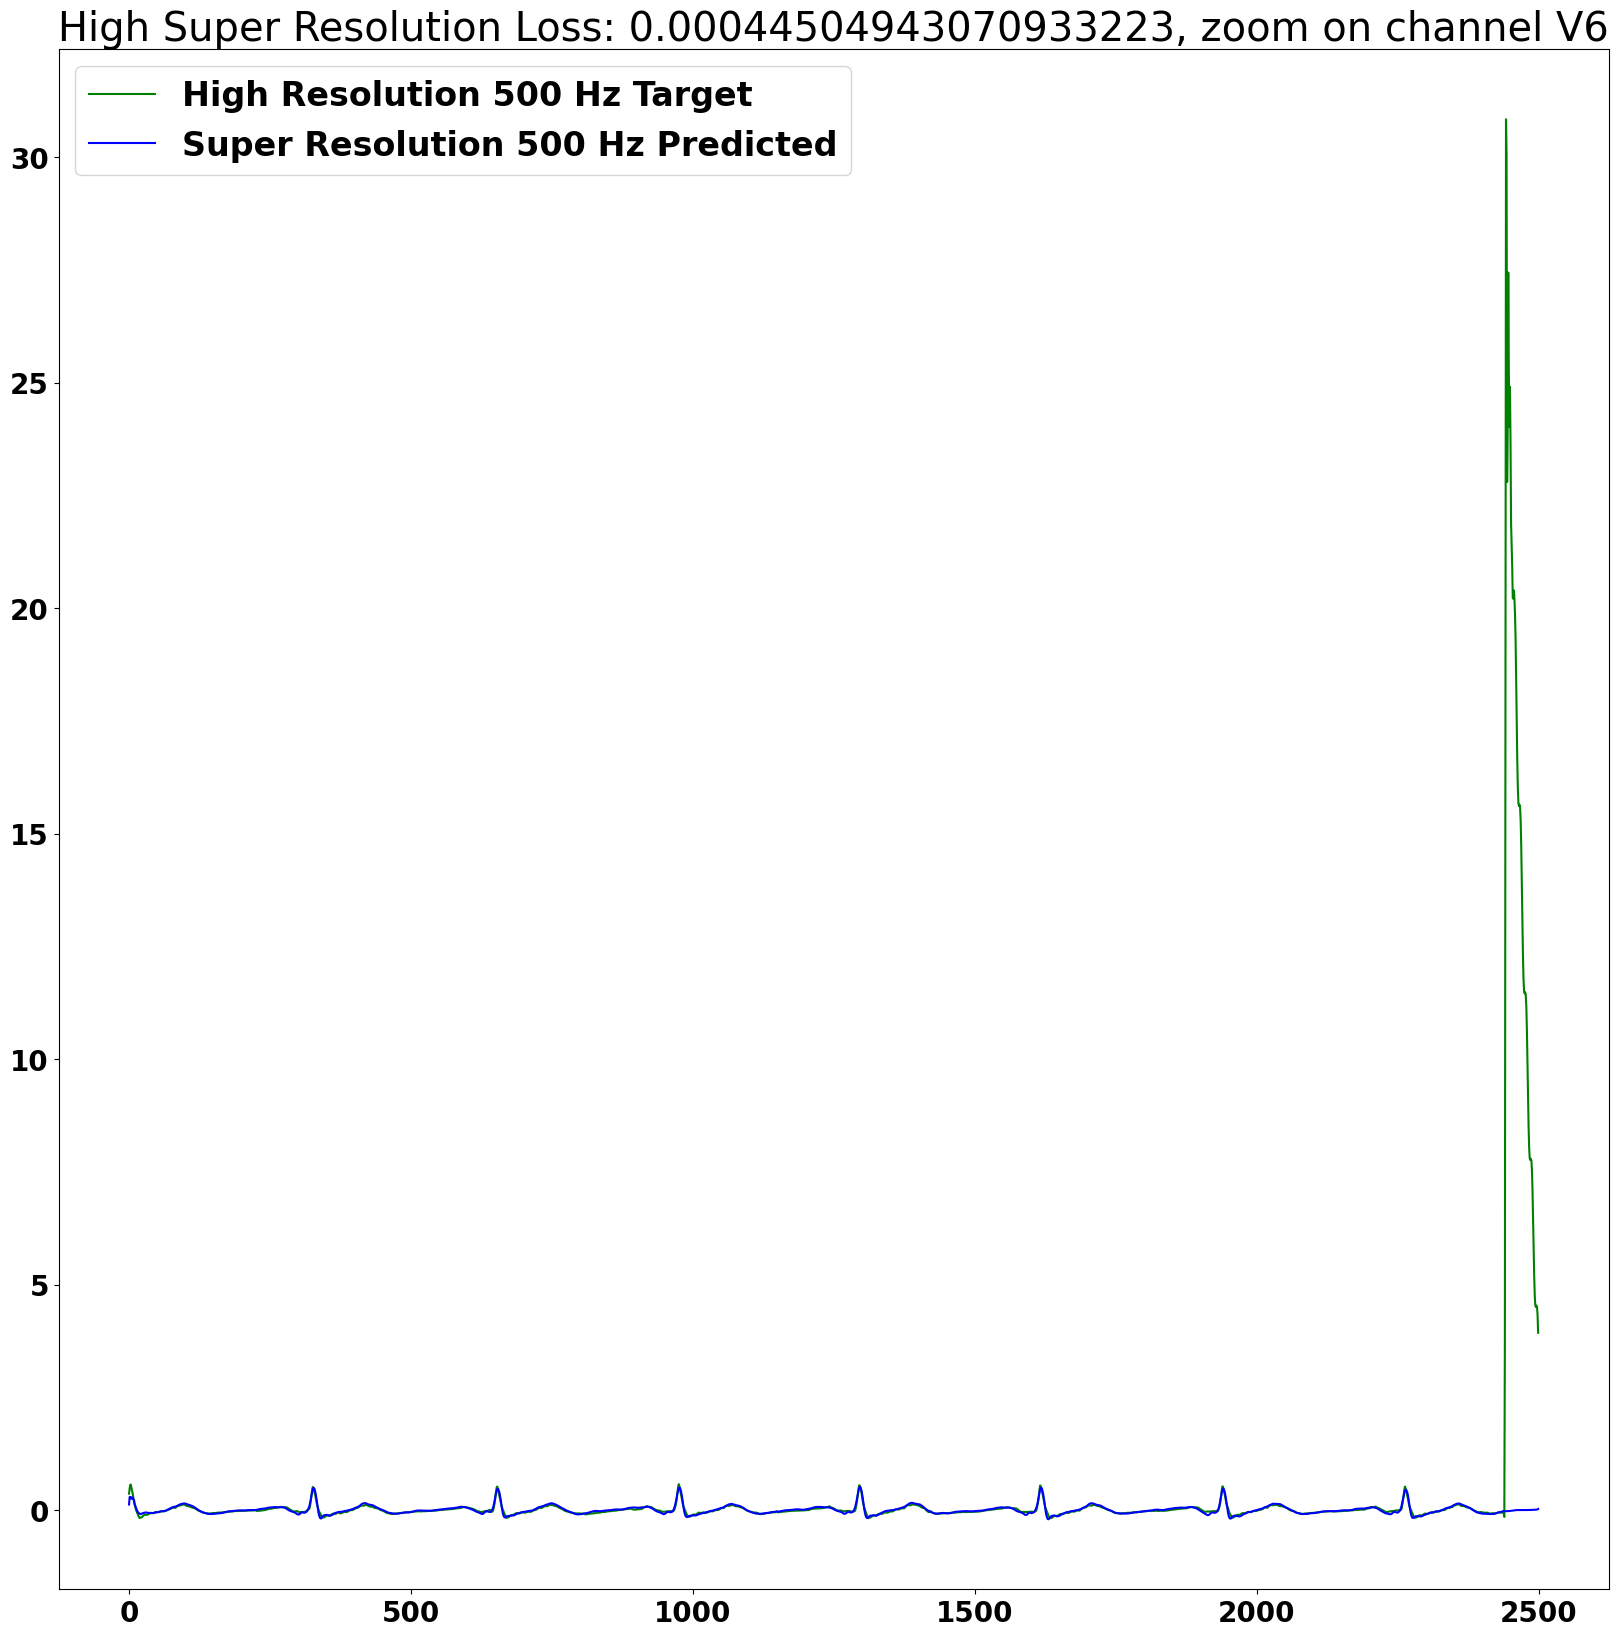

In [ ]:
loss = losses[sort_idxs[-1]]
hr_data = dict_windows_test_hr[label][sort_idxs[0]]
lr_data = dict_windows_test_lr_n[label][sort_idxs[0]]
model = model.to(device)
sr_data = model([lr_data, None])[1]
fig = plt.figure(figsize=(20, 20))
ch = 11
plt.title("High Super Resolution Loss: {}, zoom on channel {}".format(loss, channels_map[ch]))
plt.plot(hr_data[0, ch, :].cpu().detach().numpy(), "g", label = "High Resolution 500 Hz Target")
plt.plot(sr_data[ch, :].cpu().detach().numpy(), "b", label = "Super Resolution 500 Hz Predicted")
plt.legend()
fig.savefig("highsrloss_window{}_label{}.png".format(idx, label))

(2500,)


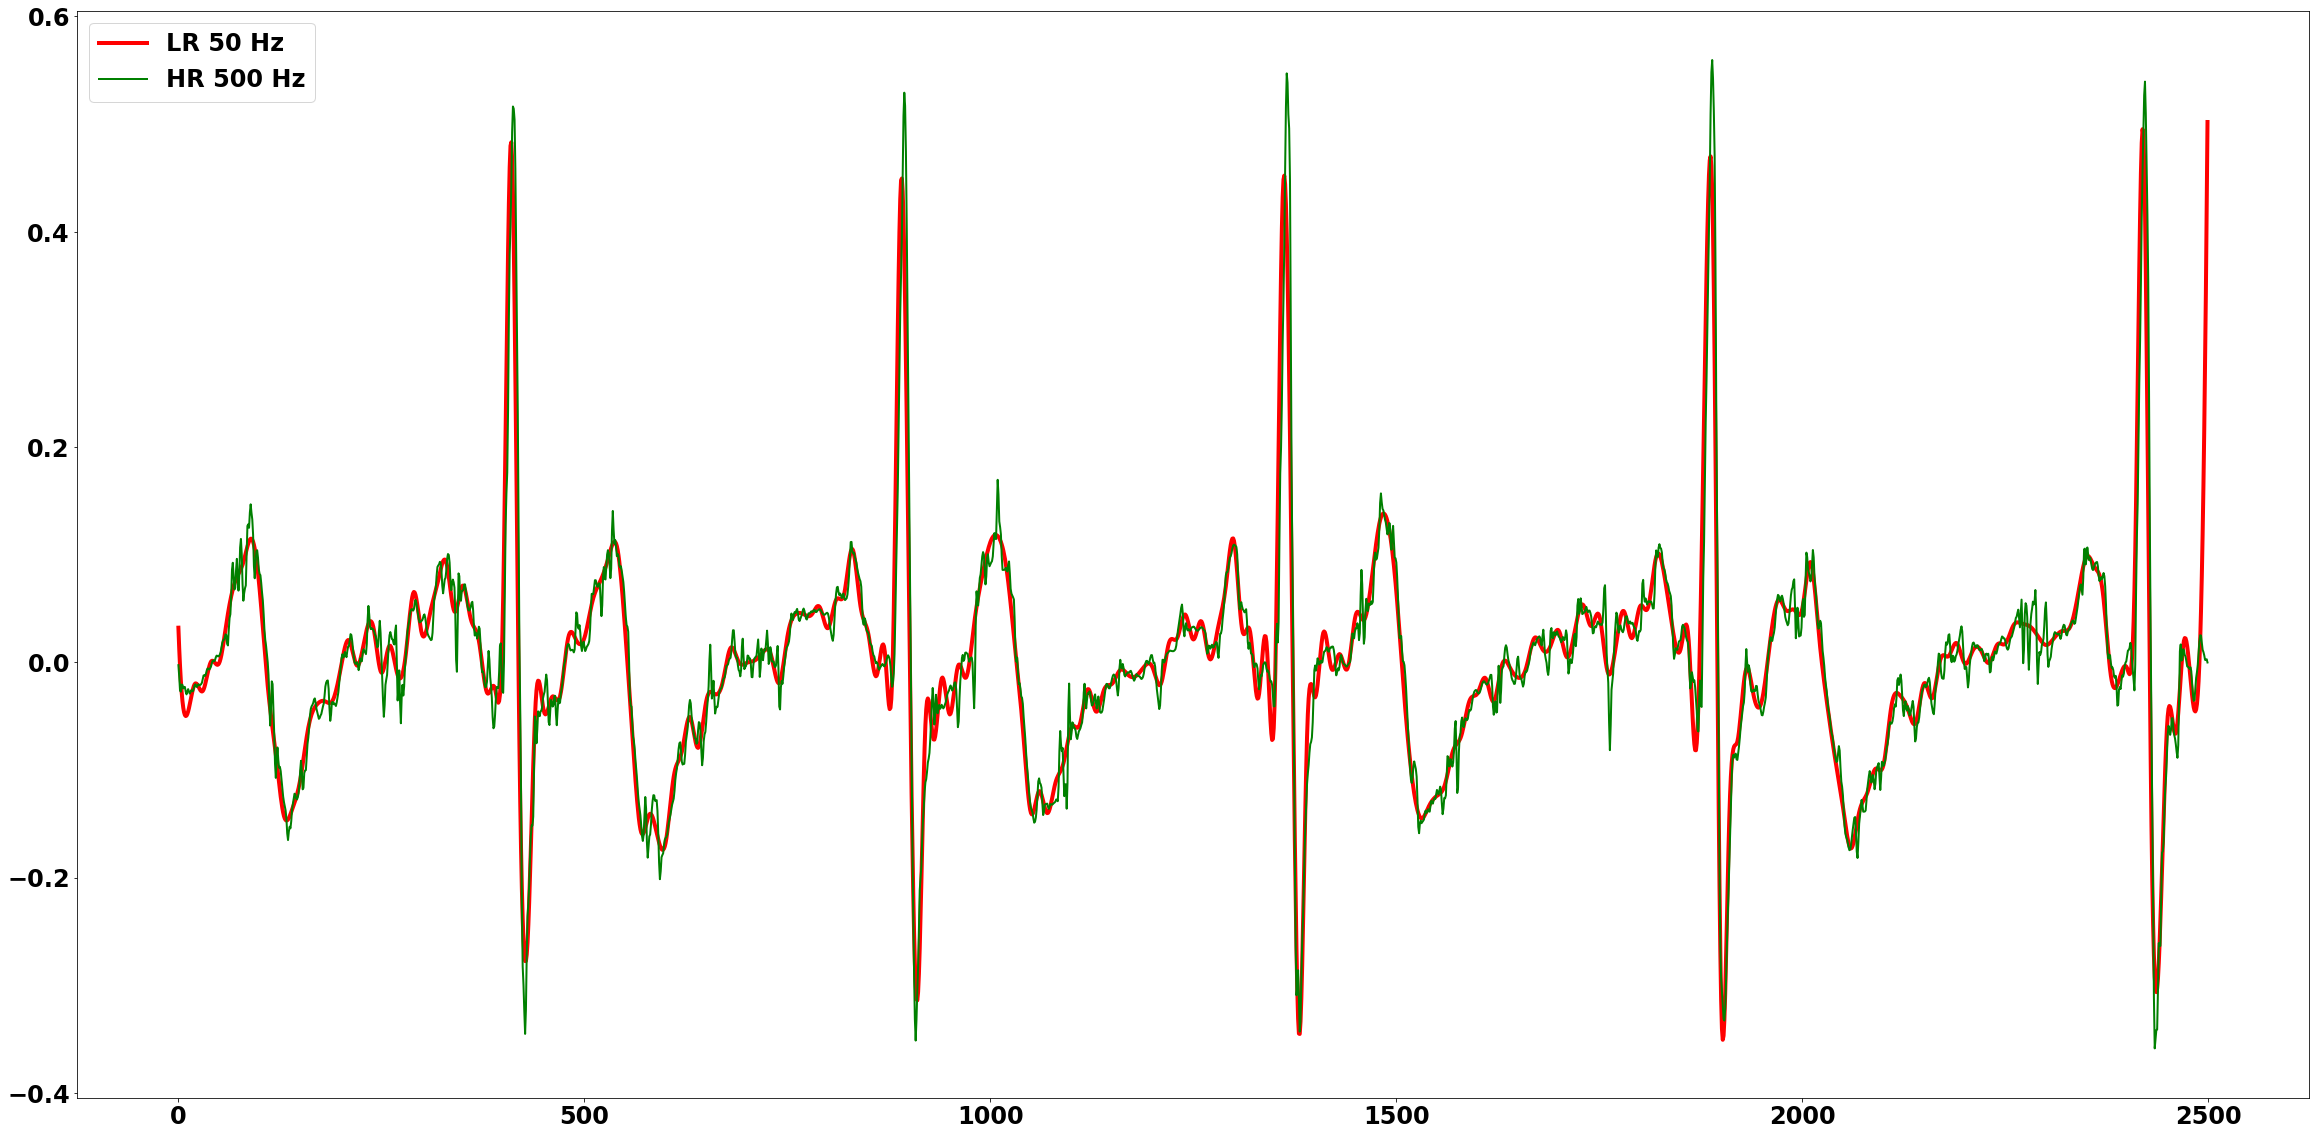

In [ ]:
idx = 0
ch = 0
label = "MI"
lr_data = dict_windows_test_lr_n[label][idx][0, 0].cpu()
hr_data = dict_windows_test_hr[label][idx][0, 0].cpu()
fs_lr = 50
fs_hr = 500
t_low_res = np.arange(0, 5, 1/fs_lr)
t_high_res = np.arange(0, 5, 1/fs_hr)
f_interp = interpolate.interp1d(t_low_res, lr_data, kind='cubic', fill_value="extrapolate")
lr_up = f_interp(t_high_res)
fig = plt.figure(figsize = (40, 20))
colors = ["r", "g"]
print(lr_up.shape)
datas = [lr_up, hr_data]
labels = ["LR 50 Hz", "HR 500 Hz"]
widths = [4, 2]
for i, data in enumerate(datas):
    label = labels[i]
    color = colors[i]
    width = widths[i]
    plt.plot(data, color = color, label = label, linewidth = width)
plt.legend()

In [ ]:
signals_test.shape

torch.Size([1088, 1, 12, 250])

In [ ]:
label = "MI"
signals_test = dict_windows_test_lr_n[label]
model = models["DCAE"]
interpolation_modes = ["linear", "nearest", "nearest-up", "zero", "slinear", "quadratic", "cubic", "previous", "next"]
df2 = pd.DataFrame(columns=columns)
for i, mode in enumerate(interpolation_modes):

    print(mode)
    t0 = time.time()

    signals_test_sr = interpolate_sr(signals_test.cpu(), fs_lr=50, fs_hr = 500, nchs=12, mode = mode)

    #compute mse
    mses, mse = compute_mse(signals_test_sr, signals_test_hr)
    #compute ssmi
    ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
    #compute psnr
    psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)
    tend = time.time()
    ex_time = round(tend-t0, 3)
    values = [mode, mse, ssim, psnr, ex_time]
    df2.loc[i] = values
df2

linear
nearest
nearest-up
zero
slinear
quadratic
cubic
previous
next


,Method,MSE,SSIM,PSNR,Time (s)
0,linear,0.183642,0.963952,14.831941,2.224
1,nearest,0.188369,0.961090,13.677280,1.654
2,nearest-up,0.189529,0.960622,13.393217,1.631
3,zero,0.190534,0.960136,13.067753,1.867
4,slinear,0.183642,0.963952,14.831941,1.924
5,quadratic,0.184549,0.965710,14.904421,2.108
6,cubic,0.185235,0.967726,14.789180,2.207
7,previous,0.190534,0.960136,13.067753,1.670
8,next,NaN,NaN,NaN,1.659


In [ ]:
t0 = time.time()
signals_test_sr = compute_sr(signals_test, sr_our_proposed_onlysignals)

if signals_test_sr.ndim == 3:
  signals_test_sr = torch.unsqueeze(signals_test_sr, dim = 1)

#compute mse
mse = compute_mse(signals_test_sr, signals_test_hr)
#compute ssmi
ssim = compute_ssim(signals_test_sr, signals_test_hr)
#compute psnr
psnr = compute_psnr(signals_test_sr, signals_test_hr)
tend = time.time()
ex_time = round(tend-t0, 3)
values = ["our proposed (S)", mse, ssim, psnr, ex_time]
df2.loc[i+1] = values

 1088 / 1088

In [ ]:
df2.set_index('Method', inplace = True)
df2

,MSE,SSIM,PSNR,Time (s)
Method,,,,
linear,0.183642,0.963952,14.831941,2.224
nearest,0.188369,0.961090,13.677280,1.654
nearest-up,0.189529,0.960622,13.393217,1.631
zero,0.190534,0.960136,13.067753,1.867
slinear,0.183642,0.963952,14.831941,1.924
quadratic,0.184549,0.965710,14.904421,2.108
cubic,0.185235,0.967726,14.789180,2.207
previous,0.190534,0.960136,13.067753,1.670
next,NaN,NaN,NaN,1.659


In [ ]:
results_path = os.getcwd() + os.sep + "results" + os.sep
df2.to_csv(results_path+"super_resolution_baseline_interpolation_signalonly.csv")

 1 / 1

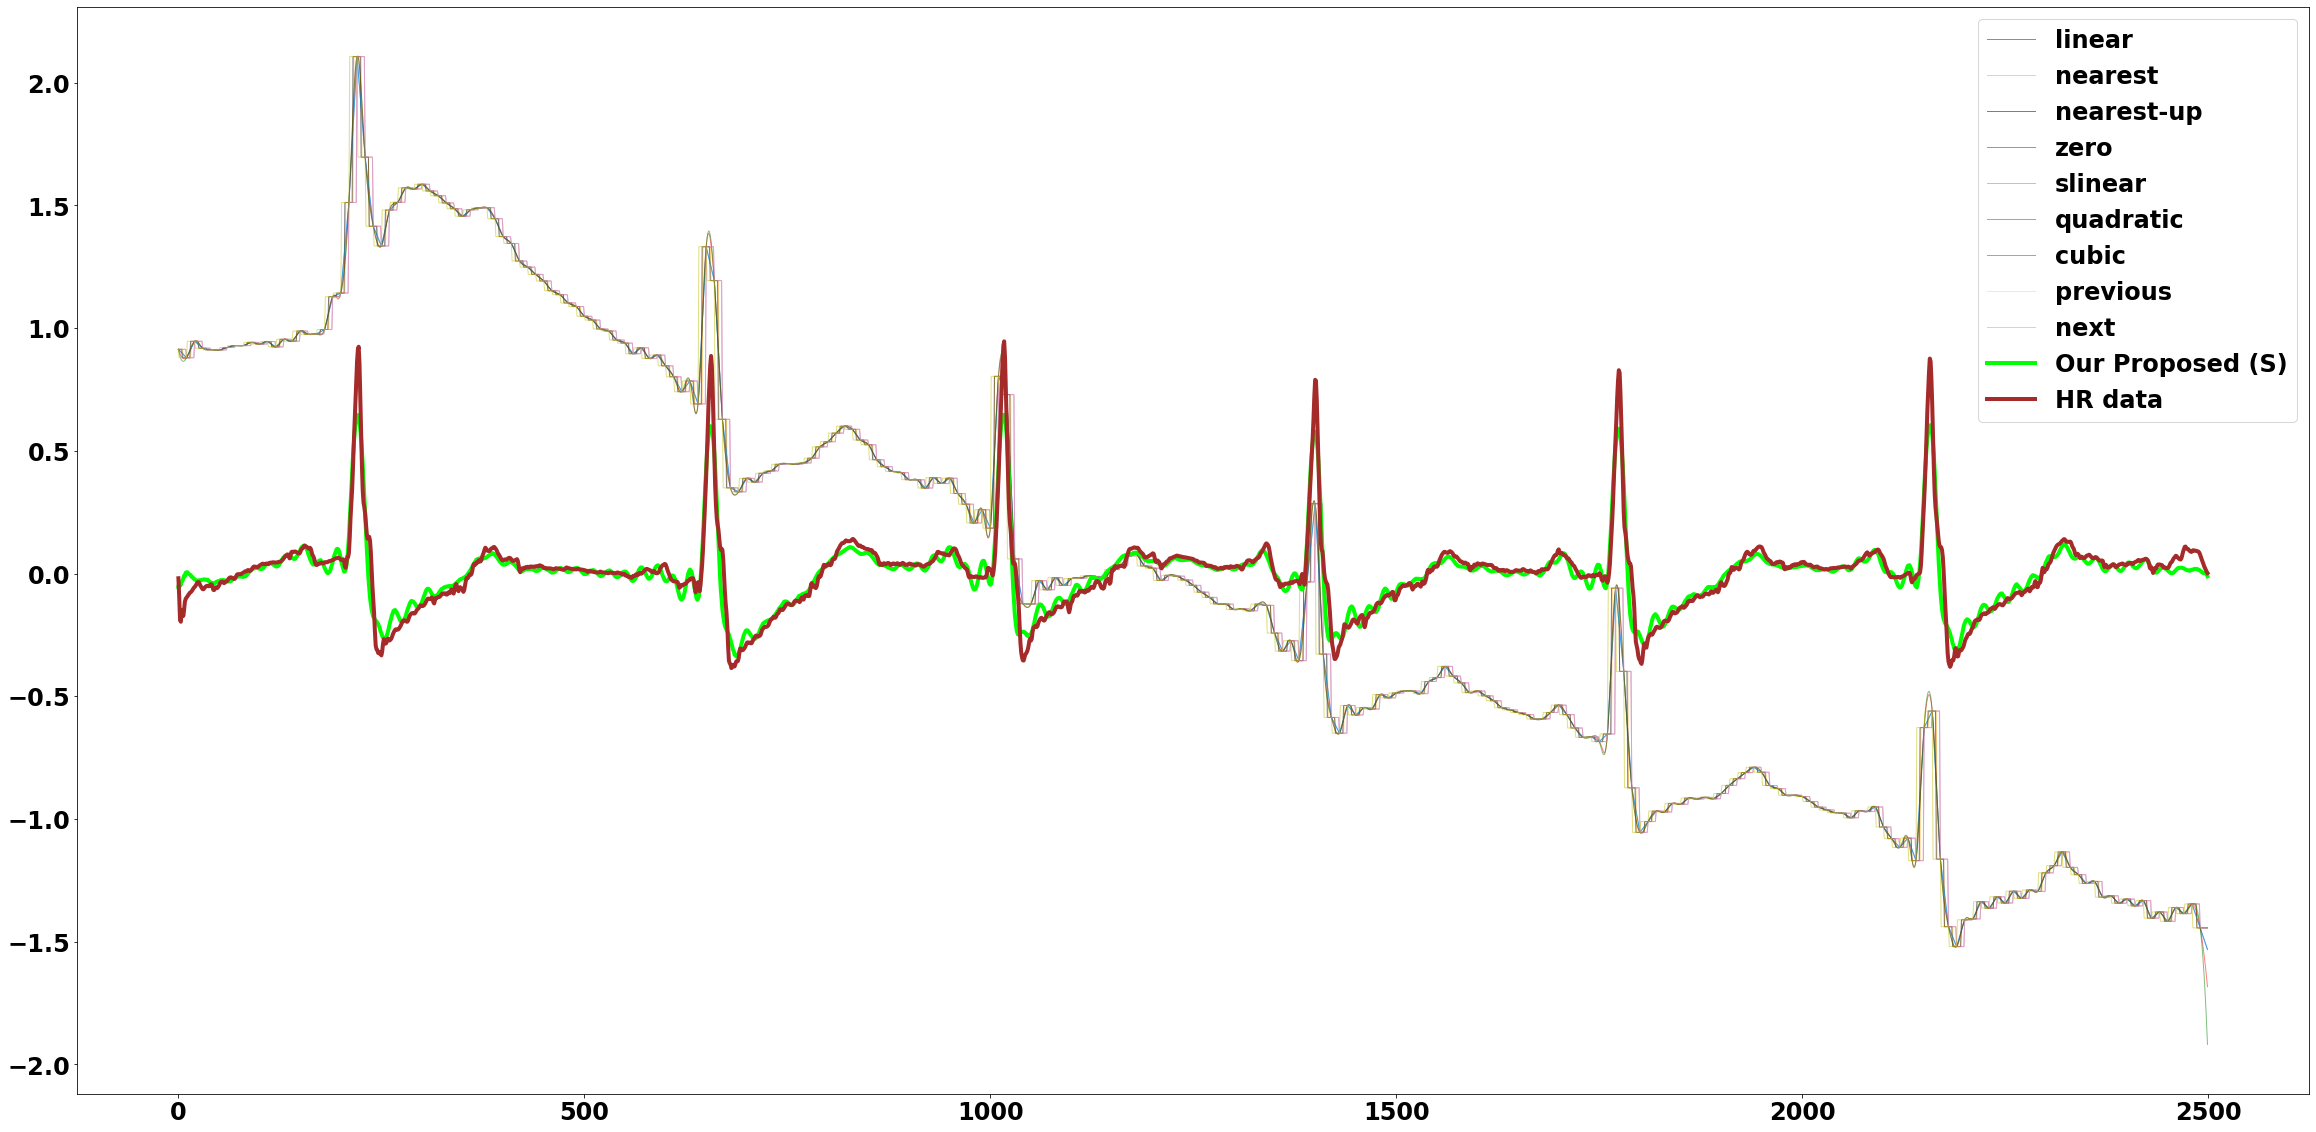

In [ ]:
idx = 150
nchs = 12
ch = 0
label = "MI"
lr_data = dict_windows_test_lr_n[label][idx][ch].cpu()
hr_data = dict_windows_test_hr[label][idx][ch].cpu()
fig = plt.figure(figsize = (40, 20))

colors = ["b", "orange", "k", "purple", "c", "r", "g", "pink", "y", "brown", "lime"]

while True:
    if lr_data.ndim == 4:
        break
    else:
        lr_data = torch.unsqueeze(lr_data, dim = 0)

while True:
    if hr_data.ndim == 4:
        break
    else:
        hr_data = torch.unsqueeze(hr_data, dim = 0)

for i, mode in enumerate(interpolation_modes):

    sr_data = interpolate_sr(lr_data, fs_lr=50, fs_hr = 500, nchs=12, mode = mode)
    color = colors[i]
    plt.plot(sr_data[0, 0, ch, :], color = color, label = mode, linewidth = 1, alpha = 0.5)

sr_data = compute_sr(lr_data, sr_our_proposed_onlysignals)
plt.plot(sr_data[0, 0, ch, :], color = colors[-1], label = "Our Proposed (S)", linewidth = 4)
plt.plot(hr_data[0, 0, ch, :], color = colors[-2], label = "HR data", linewidth = 4)
plt.legend()

# Wavelets super resolution

In [ ]:
dict_train_wavelets_lr = {}
dict_train_wavelets_hr = {}
dict_test_wavelets_lr = {}
dict_test_wavelets_hr = {}
pt_data_path = os.getcwd() + os.sep + "wavelets"
labels = ["MI"] #per ora solo uno

for label in labels:

    print(label)
    filename = pt_data_path+ os.sep + "train_wavelets_{}.pt".format(label)
    print("train LR")
    train_lr = torch.load(filename)
    dict_train_wavelets_lr[label] = train_lr

    filename = pt_data_path+ os.sep + "train_wavelets_{}_hr.pt".format(label)
    print("train HR")
    train_hr = torch.load(filename)
    dict_train_wavelets_hr[label] = train_hr


    filename = pt_data_path+ os.sep + "test_wavelets_{}.pt".format(label)
    print("test LR")
    test_lr = torch.load(filename)
    dict_test_wavelets_lr[label] = test_lr

    filename = pt_data_path+ os.sep + "test_wavelets_{}_hr.pt".format(label)
    print("test HR")
    test_hr = torch.load(filename)
    dict_test_wavelets_hr[label] = test_hr

MI
train LR
train HR
test LR
test HR


In [ ]:
len(t_low_res), len(y)

(500, 97)

In [ ]:
def signalPower(x):
    return np.average(x**2)

def SNR(sr, hr):

    noise = sr-hr
    powT = signalPower(hr)
    powN = signalPower(noise)
    return 10*np.log10(powT/powN)

In [ ]:
idx = 0
lr_data = dict_windows_test_lr_n[label][idx]
hr_data = dict_windows_test_hr[label][idx]
preds = model([lr_data, None])
sr = preds[1]
snr_db =  SNR(sr.cpu().detach().numpy(), hr_data.cpu().detach().numpy())
snr_db

11.49458646774292

In [ ]:
snrs = []
for label in labels:
    print(label)
    x_lr = dict_windows_test_lr_n[label]
    for i, lr_data in enumerate(x_lr):
        hr_data = dict_windows_test_hr[label][i]
        preds = model([lr_data, None])
        sr = preds[1]
        snr_db =  SNR(sr.cpu().detach().numpy(), hr_data.cpu().detach().numpy())
        snrs.append(snr_db)

MI
STTC
CD
HYP
NORM


In [ ]:
np.mean(snrs)

9.798864273369947

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
models = {
          "v1": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_lrhr.pt").to(device),
          "v2": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_lrhr_v2.pt").to(device)
}

In [ ]:
df = pd.DataFrame(columns = ["Superclass", "MSE", "SSIM", "PSNR"])

losses_label = {}
model = models["v1"]
for i, label in enumerate(labels):

    model.eval()

    signals_test = dict_windows_test_lr_n[label]
    signals_test_hr = dict_windows_test_hr[label]

    signals_test_sr = compute_sr(signals_test, sr_our_proposed_onlysignals)

    #compute mse
    mses, mse  = compute_mse(signals_test_sr, signals_test_hr)
    #compute ssmi
    ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
    #compute psnr
    psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)
    df.loc[i] = [label, mse, ssim, psnr]
    losses_label[label] = mses

df

 1926 / 1926

,Superclass,MSE,SSIM,PSNR
0,MI,0.005542,0.994608,25.051293
1,STTC,0.004953,0.994896,25.559456
2,CD,0.013195,0.989319,23.393080
3,HYP,0.013702,0.987744,20.777716
4,NORM,0.003545,0.995975,26.166072


In [ ]:
df = pd.DataFrame(columns = ["Superclass", "MSE", "SSIM", "PSNR"])

losses_label = {}
model = models["v2"]
for i, label in enumerate(labels):

    model.eval()

    signals_test = dict_windows_test_lr_n[label]
    signals_test_hr = dict_windows_test_hr[label]

    decoder = model.decoder.decoder
    decoder_sr = model.upsample.decoder
    n_blocks = len(decoder)
    for j, block in enumerate(decoder):
      if j+1 == n_blocks:
         block.last_tanh = False
      else:
        block.last_tanh = True
    for j, block in enumerate(decoder_sr):
      if j+1 == n_blocks:
        block.last_tanh = False
      else:
        block.last_tanh = True


    signals_test_sr = compute_sr(signals_test, sr_our_proposed_onlysignals)

    #compute mse
    mses, mse  = compute_mse(signals_test_sr, signals_test_hr)
    #compute ssmi
    ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
    #compute psnr
    psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)
    df.loc[i] = [label, mse, ssim, psnr]
    losses_label[label] = mses

df

 1926 / 1926

,Superclass,MSE,SSIM,PSNR
0,MI,0.003992,0.997919,25.701348
1,STTC,0.003443,0.997736,26.444176
2,CD,0.008078,0.996578,24.256910
3,HYP,0.007915,0.996840,22.990398
4,NORM,0.002994,0.997698,26.807766


In [ ]:
df = pd.DataFrame(columns = ["Superclass", "Min MSE", "Max MSE", "Mean MSE (+- STD)"])

losses_label = {}
model = models["v2"]
for i, label in enumerate(labels):

    model.eval()

    signals_test = dict_windows_test_lr_n[label]
    signals_test_hr = dict_windows_test_hr[label]

    decoder = model.decoder.decoder
    decoder_sr = model.upsample.decoder
    n_blocks = len(decoder)
    for j, block in enumerate(decoder):
      if j+1 == n_blocks:
         block.last_tanh = False
      else:
        block.last_tanh = True
    for j, block in enumerate(decoder_sr):
      if j+1 == n_blocks:
        block.last_tanh = False
      else:
        block.last_tanh = True


    signals_test_sr = compute_sr(signals_test, sr_our_proposed_onlysignals)

    #compute mse
    mses, mse  = compute_mse(signals_test_sr, signals_test_hr)
    min_ = min(mses)
    max_ = max(mses)
    std = np.std(mses)
    df.loc[i] = [label, min_, max_, "{}(+/-{})".format(mse, std)]
    losses_label[label] = mses

df

 1926 / 1926

,Superclass,Min MSE,Max MSE,Mean MSE (+- STD)
0,MI,0.000438,0.087876,0.003992201326876538(+/-0.005963558267656456)
1,STTC,0.000513,0.079430,0.0034433502076123184(+/-0.005801800785535133)
2,CD,0.000445,0.507681,0.008077633132319422(+/-0.02661475386746665)
3,HYP,0.000673,0.116208,0.007914729440703103(+/-0.012310118970108615)
4,NORM,0.000420,0.569445,0.002993756492002282(+/-0.013507807236544038)


In [ ]:
df = pd.DataFrame(columns = ["Last Tanh", "MSE", "SSIM", "PSNR"])
label = "MI"
i = 0
for name, model in models.items():

    model.eval()
    signals_test = dict_windows_test_lr_n[label]
    signals_test_hr = dict_windows_test_hr[label]

    if "v1" in name:
        act = "V"
    else:
        act = "X"

    print(act)

    decoder = model.decoder.decoder
    decoder_sr = model.upsample.decoder
    n_blocks = len(decoder)
    if act == "X":

      for j, block in enumerate(decoder):
        if j+1 == n_blocks:
          block.last_tanh = False
        else:
          block.last_tanh = True
      for j, block in enumerate(decoder_sr):
        if j+1 == n_blocks:
          block.last_tanh = False
        else:
          block.last_tanh = True

    signals_test_sr = compute_sr(signals_test, sr_our_proposed_onlysignals)

    #compute mse
    mses, mse  = compute_mse(signals_test_sr, signals_test_hr)
    #compute ssmi
    ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
    #compute psnr
    psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)

    values = [act, mse, ssim, psnr]
    df.loc[i] = values
    i+=1
    del signals_test_sr
df

V
 1088 / 1088X
 1088 / 1088

,Last Tanh,MSE,SSIM,PSNR
0,V,0.005542,0.994608,25.051293
1,X,0.003992,0.997919,25.701348


In [ ]:
models["v1"]

VAE1d_SR_multimodal(
  (encoder): Encoder1d(
    (encoder): Sequential(
      (0): EncoderBlock1d(
        (conv1d_in): Conv1d(12, 12, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=False)
        (conv1d_out): Conv1d(12, 192, kernel_size=(3,), stride=(1,))
        (activation_out): Tanh()
        (dropout_out): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderBlock1d(
        (conv1d_in): Conv1d(192, 384, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=False)
        (conv1d_out): Conv1d(384, 768, kernel_size=(3,), stride=(1,))
        (activation_out): Tanh()
        (dropout_out): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Decoder1d(
    (decoder): Sequential(
      (0): DecoderBlock1d(
        (conv1d_in): ConvTranspose1d(768, 768, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=

In [ ]:
models["v2"]

VAE1d_SR_multimodal(
  (encoder): Encoder1d(
    (encoder): Sequential(
      (0): EncoderBlock1d(
        (conv1d_in): Conv1d(12, 12, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=False)
        (conv1d_out): Conv1d(12, 192, kernel_size=(3,), stride=(1,))
        (activation_out): Tanh()
        (dropout_out): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderBlock1d(
        (conv1d_in): Conv1d(192, 384, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=False)
        (conv1d_out): Conv1d(384, 768, kernel_size=(3,), stride=(1,))
        (activation_out): Tanh()
        (dropout_out): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Decoder1d(
    (decoder): Sequential(
      (0): DecoderBlock1d(
        (conv1d_in): ConvTranspose1d(768, 768, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=

In [ ]:
import plotly
import plotly.graph_objects as go


fig = go.Figure()

colors = ["red", "orange", "yellow", "green", "cyan"]
for i, (label, losses) in enumerate(losses_label.items()):

    c = colors[i]
    fig.add_trace(go.Box(y=losses,
            boxpoints='suspectedoutliers', # can also be outliers, or suspectedoutliers, or False
            jitter = 0.2, # add some jitter for a better separation between points
            pointpos= -0.5, # relative position of points wrt box
            name = label,
            line_width = 2,
            line_color='black',
            fillcolor = c
        )
    )

fig.update_layout(autosize = False, width = 800, height = 800, template = "simple_white")
fig.show()

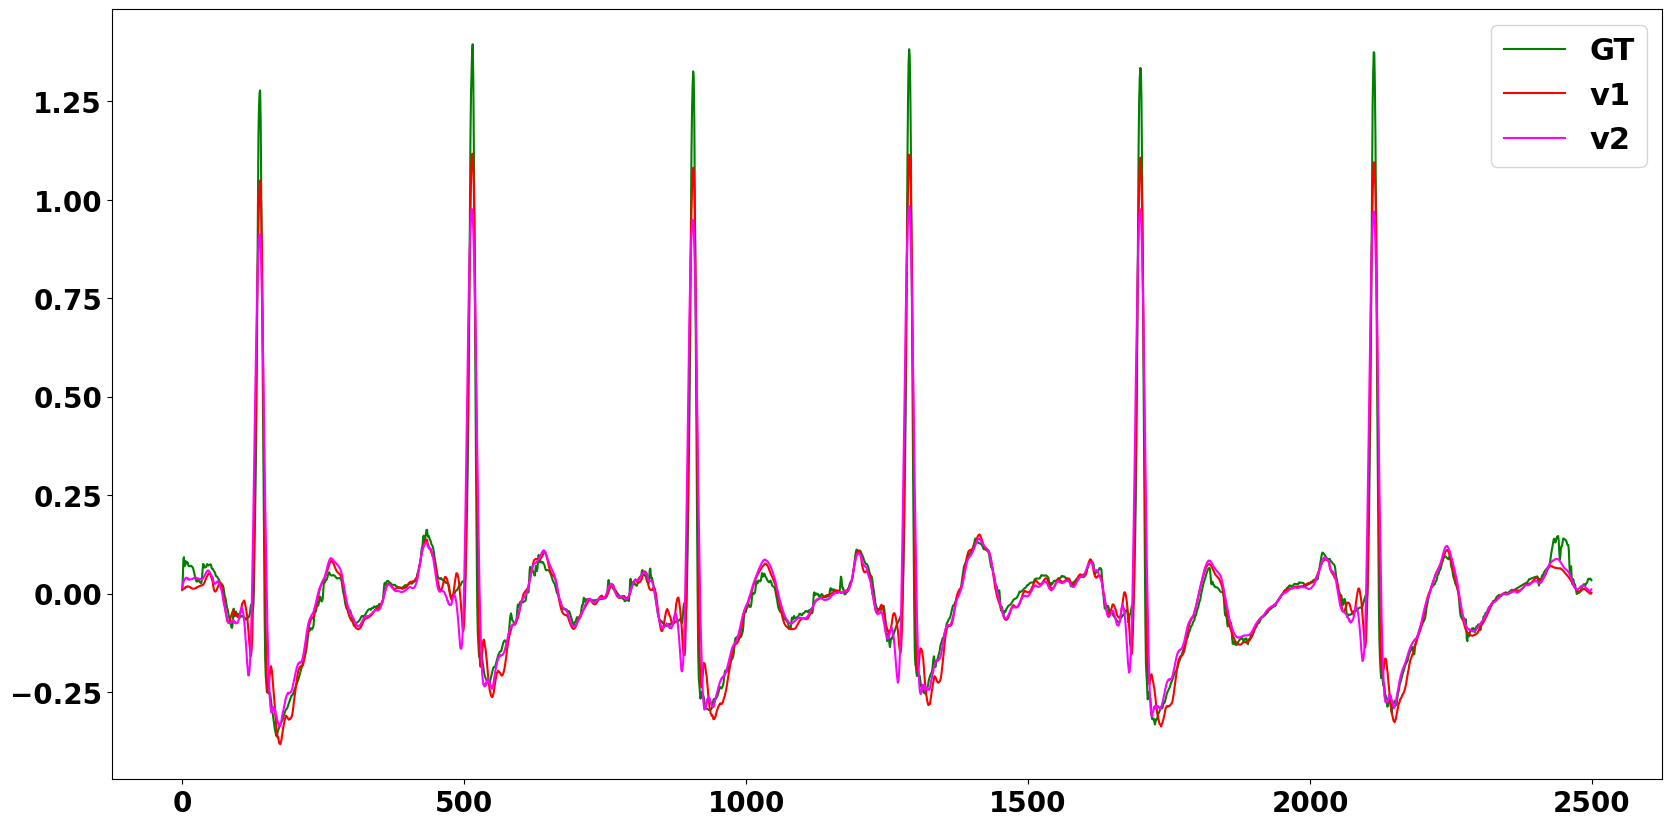

In [ ]:
import matplotlib
from matplotlib import pyplot as plt

font = {'family' : '',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

label = "NORM"
idx = 50
ch = 1
lr_data = dict_windows_test_lr_n[label][idx]
hr_data = dict_windows_test_hr[label][idx]
sr_1 = models["v1"]([lr_data, None])[1]
sr_2 = models["v2"]([lr_data, None])[1]
plt.figure(figsize = (20, 10))
plt.plot(hr_data[0, ch, :].cpu().detach().numpy(), "g", label = "GT")
plt.plot(sr_1[ch, :].cpu().detach().numpy(), "r", label = "v1")
plt.plot(sr_2[ch, :].cpu().detach().numpy(), "magenta", label = "v2")
plt.legend()

In [ ]:
import plotly
import plotly.graph_objects as go


fig = go.Figure()

colors = ["red", "orange", "yellow", "green", "cyan"]
for i, (label, losses) in enumerate(losses_label.items()):

    c = colors[i]
    fig.add_trace(go.Box(y=losses,
            boxpoints='suspectedoutliers', # can also be outliers, or suspectedoutliers, or False
            jitter = 0.2, # add some jitter for a better separation between points
            pointpos= -0.5, # relative position of points wrt box
            name = label,
            line_width = 2,
            line_color='black',
            fillcolor = c
        )
    )

fig.update_layout(autosize = False, width = 800, height = 800, template = "simple_white")
fig.show()

In [ ]:
models["v1"]

VAE1d_SR_multimodal(
  (encoder): Encoder1d(
    (encoder): Sequential(
      (0): EncoderBlock1d(
        (conv1d_in): Conv1d(12, 12, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=False)
        (conv1d_out): Conv1d(12, 192, kernel_size=(3,), stride=(1,))
        (activation_out): Tanh()
        (dropout_out): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderBlock1d(
        (conv1d_in): Conv1d(192, 384, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=False)
        (conv1d_out): Conv1d(384, 768, kernel_size=(3,), stride=(1,))
        (activation_out): Tanh()
        (dropout_out): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Decoder1d(
    (decoder): Sequential(
      (0): DecoderBlock1d(
        (conv1d_in): ConvTranspose1d(768, 768, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=

In [ ]:
!ls

 activationmap_superresolution_labelCD_ch0-1_noised.png
 activationmap_superresolution_labelCD_nonoise.png
 activationmap_superresolution_labelCD.png
 activationmap_superresolution_labelHYP_ch0-1_noised.png
 activationmap_superresolution_labelHYP_nonoise.png
 activationmap_superresolution_labelHYP.png
 activationmap_superresolution_labelMI_ch0-1_noised.png
 activationmap_superresolution_labelMI_nonoise.png
 activationmap_superresolution_labelMI.png
 activationmap_superresolution_labelNORM_ch0-1_noised.png
'activationmap_superresolution_labelNORM_idx10_noiseEDA artifact.png'
'activationmap_superresolution_labelNORM_idx10_noiseEMG artifact.png'
 activationmap_superresolution_labelNORM_idx10_noiseNO.png
'activationmap_superresolution_labelNORM_idx10_noiseRespiration Noise.png'
 activationmap_superresolution_labelNORM_nonoise.png
 activationmap_superresolution_labelNORM.png
 activationmap_superresolution_labelSTTC_ch0-1_noised.png
 activationmap_superresolution_labelSTTC_nonoise.png
 activ

In [ ]:
models = {
          "only MI": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_lrhr_v2.pt").to(device),
          "All": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_all_denoising_lrhr.pt").to(device)
}

In [ ]:
def compute_our_sr(signals, model):

    signals_sr = []
    n = len(signals)
    clear_cache = np.arange(200, n, 200)
    for i, signal in enumerate(signals):
        if i in clear_cache:
          gc.collect()
          torch.cuda.empty_cache()
        print("\r", i+1, "/", n, end = "")
        pred = model([signal, None, None, None])
        signal_sr = pred[1].to("cpu").detach().numpy()
        signals_sr.append(signal_sr)
        del signal_sr
        del signal
        del pred
    signals_sr = torch.from_numpy(np.array(signals_sr))
    return signals_sr

In [ ]:
df = pd.DataFrame(columns = ["Train on", "MSE", "SSIM", "PSNR"])
losses_label = {}

gc.collect()
torch.cuda.empty_cache()
for i, (name, model) in enumerate(models.items()):
    model.eval()

    decoder = model.decoder.decoder
    decoder_sr = model.upsample.decoder
    n_blocks = len(decoder)
    for j, block in enumerate(decoder):
      if j+1 == n_blocks:
        block.last_tanh = False
      else:
        block.last_tanh = True
    for j, block in enumerate(decoder_sr):
      if j+1 == n_blocks:
        block.last_tanh = False
      else:
        block.last_tanh = True

    losses_label[name] = {}
    mses = []
    ssims = []
    psnrs = []
    for label in labels:

      signals_test = dict_windows_test_lr_n[label]
      signals_test_hr = dict_windows_test_hr[label]

      signals_test_sr = compute_our_sr(signals_test, model)

      #compute mse
      losses, mse  = compute_mse(signals_test_sr, signals_test_hr)
      #compute ssmi
      _, ssim = compute_ssim(signals_test_sr, signals_test_hr)
      #compute psnr
      _, psnr = compute_psnr(signals_test_sr, signals_test_hr)

      losses_label[name][label] = losses
      mses.append(mse)
      ssims.append(ssim)
      psnrs.append(psnr)

    df.loc[i] = [name, np.mean(mses), np.mean(ssims), np.mean(psnrs)]

df

 1088 / 1088

<ipython-input-15-ef314df32b78>:7: UserWarning:

Using a target size (torch.Size([1, 12, 2500])) that is different to the input size (torch.Size([12, 2500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



 1926 / 1926

,Train on,MSE,SSIM,PSNR
0,only MI,0.005284,0.997354,25.240120
1,All,0.004413,0.998028,26.324536


In [ ]:
mses, labels

([0.003387902975164787,
  0.0027579775464480817,
  0.007052979241386626,
  0.006723156919059741,
  0.002141680921661703],
 ['MI', 'STTC', 'CD', 'HYP', 'NORM'])

In [ ]:
np.mean(mses), np.mean(psnrs), np.mean(ssims)

(0.004412739520744188, 26.324536305309373, 0.998027841674007)

In [ ]:
def RMSE(sr, hr):
  mse = F.mse_loss(sr, hr).item()
  rmse = np.sqrt(mse)
  return rmse

In [ ]:
model = models["All"].eval()

In [ ]:
snrs = []
for label in labels:
    print(label)
    x_lr = dict_windows_test_lr_n[label]
    for i, lr_data in enumerate(x_lr):
        hr_data = dict_windows_test_hr[label][i]
        preds = model([lr_data, None])
        sr = preds[1]
        snr_db = SNR(sr.cpu().detach().numpy(), hr_data.cpu().detach().numpy())
        snrs.append(snr_db)
np.mean(snrs)

MI
STTC
CD
HYP
NORM


12.198761670808787

In [ ]:
rmses = []
for label in labels:
  print(label)
  x_lr = dict_windows_test_lr_n[label]
  for i, lr_data in enumerate(x_lr):
    hr_data = dict_windows_test_hr[label][i]
    preds = model([lr_data, None])
    sr = preds[1]
    rmse = RMSE(sr, hr_data)
    rmses.append(rmse)
np.mean(rmses)

MI


<ipython-input-120-9d70646a67d3>:2: UserWarning:

Using a target size (torch.Size([1, 12, 2500])) that is different to the input size (torch.Size([12, 2500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



STTC
CD
HYP
NORM


0.04856270369149364

In [ ]:
import plotly
import plotly.graph_objects as go
import matplotlib

fig = go.Figure()

colors = ["red", "orange", "yellow", "green", "cyan"]
for i, (label, losses) in enumerate(losses_label["All"].items()):

    c = colors[i]
    fig.add_trace(go.Box(y=losses,
            boxpoints='suspectedoutliers', # can also be outliers, or suspectedoutliers, or False
            jitter = 0.2, # add some jitter for a better separation between points
            pointpos= -0.5, # relative position of points wrt box
            name = label,
            line_width = 2,
            line_color='black',
            fillcolor = c
        )
    )

fig.update_layout(autosize = False, width = 800, height = 800, template = "simple_white")
fig.show()

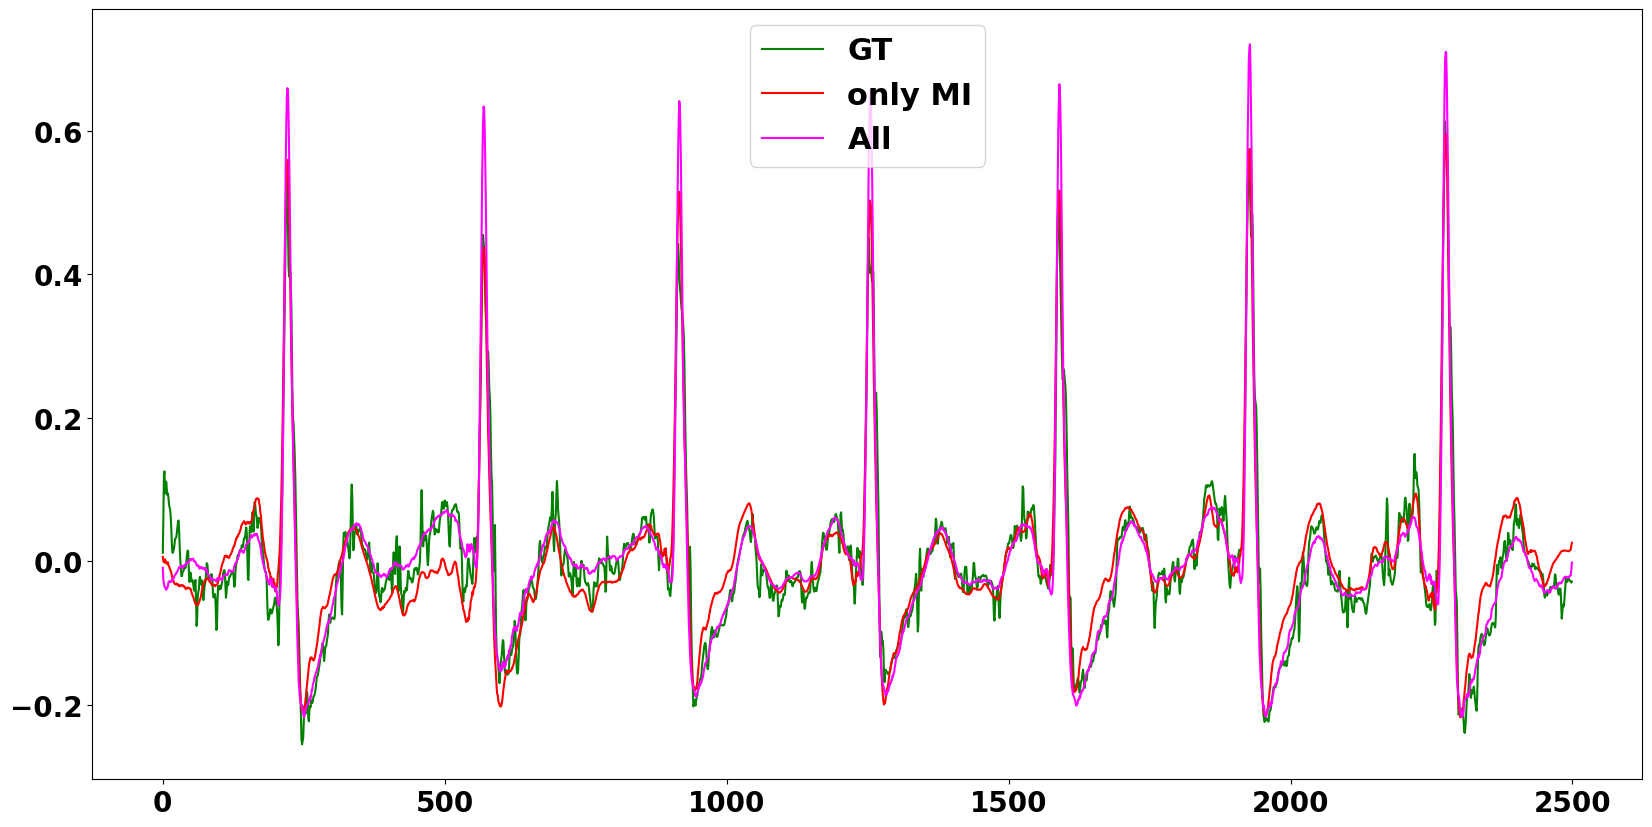

In [ ]:
from matplotlib import pyplot as plt
import matplotlib

font = {'family' : '',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

label = "HYP"
idx = 100
ch = 0
lr_data = dict_windows_test_lr_n[label][idx]
hr_data = dict_windows_test_hr[label][idx]
sr_1 = models["only MI"]([lr_data, None])[1]
sr_2 = models["All"]([lr_data, None])[1]
plt.figure(figsize = (20, 10))
plt.plot(hr_data[0, ch, :].cpu().detach().numpy(), "g", label = "GT")
plt.plot(sr_1[ch, :].cpu().detach().numpy(), "r", label = "only MI")
plt.plot(sr_2[ch, :].cpu().detach().numpy(), "magenta", label = "All")
plt.legend()